## Practical Assignment ML1: Logistic Regression on Imbalanced Data

### 1. Project Overview

In this notebook, we implement a binary Logistic Regression classifier from scratch and evaluate its performance on an imbalanced benchmark dataset. We then propose and implement a variants to mitigate class imbalance.

Sections:

2. Import Required Libraries

3. Baseline Model: Logistic Regression Implementation

4. Data Loading and Preprocessing

5. Baseline Model Training and Evaluation

6. Focal Loss Variant: Implementation and Evaluation

7. Comparative Analysis: Metrics and Visualizations

8. Advanced Visualizations and Statistical Analysis

9. Conclusions and References


## 2. Import Required Libraries

All necessary Python libraries and modules are imported here. This includes packages for data manipulation, visualization, model building, and evaluation.

In [1]:
# Standard imports
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, classification_report

from collections import Counter

# Plot styling
plt.rcParams.update({'figure.figsize': (8, 6), 'axes.grid': True})

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Numerical stability constant for losses
EPS = 1e-15

## 3. Baseline Implementation of Logistic Regression

This section details the implementation of the baseline Logistic Regression model from scratch, including utility functions and base classes.

### 3.1 Algorithm Overview

Logistic Regression is a linear classifier that models the probability of the positive class using the sigmoid of a linear combination of features. We optimize the binary cross-entropy loss via gradient descent.

### 3.2 Utilities

Helper functions for loss calculation and other utilities used in the model.

**Squared Error**  
The squared error between actual and predicted values:

* $\;(y - \hat y)^2$

**Mean Squared Error (MSE)**  
The average squared error across all samples:

* $\displaystyle \frac{1}{N}\sum_{i=1}^N (y_i - \hat y_i)^2$

**Binary Cross-Entropy (BCE)**  
The main loss function for logistic regression, measuring the difference between true labels and predicted probabilities:

* $\displaystyle -\frac{1}{N}\sum_{i=1}^N \Bigl[y_i\log(\hat y_i)+(1-y_i)\log(1-\hat y_i)\Bigr]$

In code, we use a small constant `EPS` to avoid numerical issues with $\log$. 


In [2]:
def squared_error(actual, predicted):
    return (actual - predicted) ** 2

def mean_squared_error(actual, predicted):
    return np.mean(squared_error(actual, predicted))

def binary_crossentropy(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))

### 3.3 Base Classes

Implementation of base classes for estimators and regression models.

- BaseEstimator handles input validation and provides a standard interface for fit and predict methods.

- BasicRegression extends BaseEstimator and implements the main logic for models trained with gradient descent, including regularization and intercept handling.


In [3]:
# coding:utf-8

import logging

from autograd import grad

# from mla.base import BaseEstimator ----->  https://github.com/rushter/MLAlgorithms,
# from mla.metrics.metrics import mean_squared_error, binary_crossentropy -----> https://github.com/rushter/MLAlgorithms,

np.random.seed(1000)


# coding:utf-8
import numpy as np


class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

def squared_error(actual, predicted):
    return (actual - predicted) ** 2

def mean_squared_error(actual, predicted):
    return np.mean(squared_error(actual, predicted))

def binary_crossentropy(actual, predicted):
    predicted = np.clip(predicted, EPS, 1 - EPS)
    return np.mean(-np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted)))



class BasicRegression(BaseEstimator):
    def __init__(self, lr=0.001, penalty="None", C=0.01, tolerance=0.0001, max_iters=1000):
        """Basic class for implementing continuous regression estimators which
        are trained with gradient descent optimization on their particular loss
        function.

        Parameters
        ----------
        lr : float, default 0.001
            Learning rate.
        penalty : str, {'l1', 'l2', None'}, default None
            Regularization function name.
        C : float, default 0.01
            The regularization coefficient.
        tolerance : float, default 0.0001
            If the gradient descent updates are smaller than `tolerance`, then
            stop optimization process.
        max_iters : int, default 10000
            The maximum number of iterations.
        """
        self.C = C
        self.penalty = penalty
        self.tolerance = tolerance
        self.lr = lr
        self.max_iters = max_iters
        self.errors = []
        self.theta = []
        self.n_samples, self.n_features = None, None
        self.cost_func = None

    def _loss(self, w):
        raise NotImplementedError()

    def init_cost(self):
        raise NotImplementedError()

    def _add_penalty(self, loss, w):
        """Apply regularization to the loss."""
        if self.penalty == "l1":
            loss += self.C * np.abs(w[1:]).sum()
        elif self.penalty == "l2":
            loss += (0.5 * self.C) * (w[1:] ** 2).sum()
        return loss

    def _cost(self, X, y, theta):
        prediction = X.dot(theta)
        error = self.cost_func(y, prediction)
        return error

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.init_cost()
        self.n_samples, self.n_features = X.shape

        # Initialize weights + bias term
        self.theta = np.random.normal(size=(self.n_features + 1), scale=0.5)

        # Add an intercept column
        self.X = self._add_intercept(self.X)

        self._train()

    @staticmethod
    def _add_intercept(X):
        b = np.ones([X.shape[0], 1])
        return np.concatenate([b, X], axis=1)

    def _train(self):
        self.theta, self.errors = self._gradient_descent()
        logging.info(" Theta: %s" % self.theta.flatten())

    def _predict(self, X=None):
        X = self._add_intercept(X)
        return X.dot(self.theta)

    def _gradient_descent(self):
        theta = self.theta
        errors = [self._cost(self.X, self.y, theta)]
        # Get derivative of the loss function
        cost_d = grad(self._loss)
        for i in range(1, self.max_iters + 1):
            # Calculate gradient and update theta
            delta = cost_d(theta)
            theta -= self.lr * delta

            errors.append(self._cost(self.X, self.y, theta))
            logging.info("Iteration %s, error %s" % (i, errors[i]))

            error_diff = np.linalg.norm(errors[i - 1] - errors[i])
            if error_diff < self.tolerance:
                logging.info("Convergence has reached.")
                break
        return theta, errors

### 3.4 LogisticRegression Class

Implementation of the custom Logistic Regression class, including the sigmoid function and prediction logic, for binary classification, using gradient descent to optimize the binary cross-entropy loss.

In [4]:
class LogisticRegression(BasicRegression):
    """Binary logistic regression with gradient descent optimizer."""

    def init_cost(self):
        self.cost_func = binary_crossentropy

    def _loss(self, w):
        loss = self.cost_func(self.y, self.sigmoid(np.dot(self.X, w)))
        return self._add_penalty(loss, w)

    @staticmethod
    def sigmoid(x):
        return 0.5 * (np.tanh(0.5 * x) + 1)

    def _predict(self, X=None):
        X = self._add_intercept(X)
        return self.sigmoid(X.dot(self.theta))

## 4. Data Loading and Preprocessing

This section covers loading the datasets, identifying the binary target column, and preprocessing steps such as encoding categorical variables.

### 4.1 Discover all CSV files

In [5]:
# Discover and load all CSVs from the folder
csv_files = sorted(glob.glob("class_imbalance/*.csv"))
print(f"Number of datasets found: {len(csv_files)}")


Number of datasets found: 50


### 4.2. Inspect shapes and target‐column of each CSV

In [6]:
datasets = {}
for path in csv_files:
    name = os.path.splitext(os.path.basename(path))[0]
    df = pd.read_csv(path)
    datasets[name] = df
    print(f"\nDataset: {name}")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")


Dataset: dataset_1000_hypothyroid
  Shape: (3772, 30)
  Columns: ['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', 'binaryClass']

Dataset: dataset_1002_ipums_la_98-small
  Shape: (7485, 56)
  Columns: ['year', 'gq', 'gqtypeg', 'farm', 'ownershg', 'value', 'rent', 'ftotinc', 'nfams', 'ncouples', 'nmothers', 'nfathers', 'momloc', 'stepmom', 'momrule', 'poploc', 'steppop', 'poprule', 'sploc', 'sprule', 'famsize', 'nchild', 'nchlt5', 'famunit', 'eldch', 'yngch', 'nsibs', 'relateg', 'age', 'sex', 'raceg', 'marst', 'chborn', 'school', 'educrec', 'schltype', 'empstatg', 'labforce', 'occscore', 'sei', 'classwkg', 'wkswork2', 'hrswork2', 'workedyr', 'incto

#### 4.3 Data Preprocessing and Dataset Selection


In [7]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

##### 4.3.1 Find binary target column (2 unique values) in a DataFrame

In [8]:
def find_binary_target(df: pd.DataFrame):
    for col in df.columns:
        vals = df[col].dropna().unique()
        if len(vals) == 2:
            return col
    return None

##### 4.3.2 Minimal preprocessing:

- Try to convert object columns to numeric
- Apply get_dummies to X
- Apply LabelEncoder to y

In [9]:
def preprocess_df(df: pd.DataFrame, target: str):
    df = df.copy()
    # 4.3.2.1 Convert "numeric strings" to float/int
    for c in df.select_dtypes(include=['object']).columns:
        try:
            df[c] = pd.to_numeric(df[c])
        except:
            pass

    # 4.3.2.2 Separate X and y
    X = df.drop(columns=[target])
    y = df[target].astype(str)

    # 4.3.2.3 One-hot encode X
    X = pd.get_dummies(X)

    # 4.3.2.4 Label-encode y
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    return X, y_enc

##### 4.3.3 Load all CSVs and keep only those with a binary target column

In [10]:
paths = sorted(glob.glob("class_imbalance/*.csv"))
valid_datasets = {}
for p in paths:
    name = os.path.splitext(os.path.basename(p))[0]
    df = pd.read_csv(p)
    tgt = find_binary_target(df)
    if tgt is None:
        print(f"[SKIP] {name}: no binary target column")
    else:
        valid_datasets[name] = (df, tgt)

print(f"\n Valid datasets ({len(valid_datasets)}):", list(valid_datasets.keys()))


 Valid datasets (50): ['dataset_1000_hypothyroid', 'dataset_1002_ipums_la_98-small', 'dataset_1004_synthetic_control', 'dataset_1013_analcatdata_challenger', 'dataset_1014_analcatdata_dmft', 'dataset_1016_vowel', 'dataset_1018_ipums_la_99-small', 'dataset_1020_mfeat-karhunen', 'dataset_1021_page-blocks', 'dataset_1022_mfeat-pixel', 'dataset_1023_soybean', 'dataset_1039_hiva_agnostic', 'dataset_1045_kc1-top5', 'dataset_1049_pc4', 'dataset_1050_pc3', 'dataset_1056_mc1', 'dataset_1059_ar1', 'dataset_1061_ar4', 'dataset_1064_ar6', 'dataset_1065_kc3', 'dataset_311_oil_spill', 'dataset_312_scene', 'dataset_316_yeast_ml8', 'dataset_38_sick', 'dataset_450_analcatdata_lawsuit', 'dataset_463_backache', 'dataset_757_meta', 'dataset_764_analcatdata_apnea3', 'dataset_765_analcatdata_apnea2', 'dataset_767_analcatdata_apnea1', 'dataset_865_analcatdata_neavote', 'dataset_867_visualizing_livestock', 'dataset_875_analcatdata_chlamydia', 'dataset_940_water-treatment', 'dataset_947_arsenic-male-bladder',

#### 4.4 Imbalance Distribution by Dataset

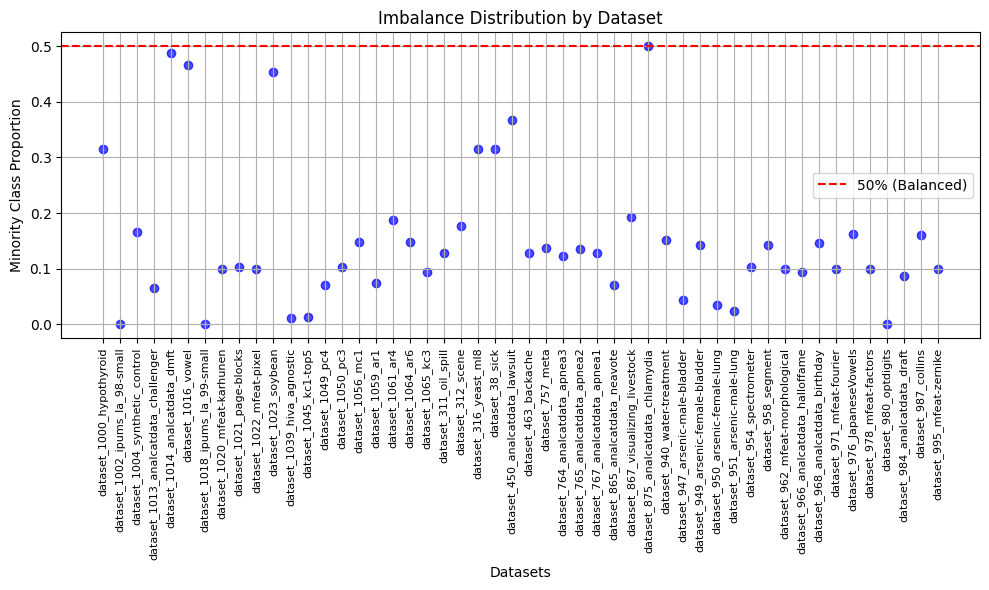

In [11]:
imbalance_ratios = []
dataset_names = []

for name, (df, target) in valid_datasets.items():
    counts = df[target].value_counts(normalize=True)
    imbalance_ratio = 1 - counts.max()  
    imbalance_ratios.append(imbalance_ratio)
    dataset_names.append(name)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dataset_names, imbalance_ratios, color='blue', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--', label='50% (Balanced)')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Datasets')
plt.ylabel('Minority Class Proportion')
plt.title('Imbalance Distribution by Dataset')
plt.legend()
plt.tight_layout()
plt.show()

#### 4.4.1 Analysis: Imbalance Distribution by Dataset (Scatter Plot)

- **What it shows:**  
  Each point represents a dataset, with the x-axis showing the dataset name and the y-axis showing the proportion of the minority class (i.e., the class with fewer samples).

- **Key observations:**

  - **Severe Imbalance:**  
    Most datasets have a minority class proportion well below 0.2, indicating strong class imbalance.

  - **Balanced Datasets:**  
    Only a few datasets approach the 0.5 line (red dashed), meaning very few are balanced.
    
  - **Outliers:**  
    Some datasets have a minority class proportion close to zero, suggesting extreme imbalance (almost all samples belong to one class).

- **Implication:**  
  The majority of datasets are highly imbalanced, which presents a challenge for standard classifiers and highlights the need for imbalance-aware methods.

#### 4.5. Class Frequencies Across Datasets

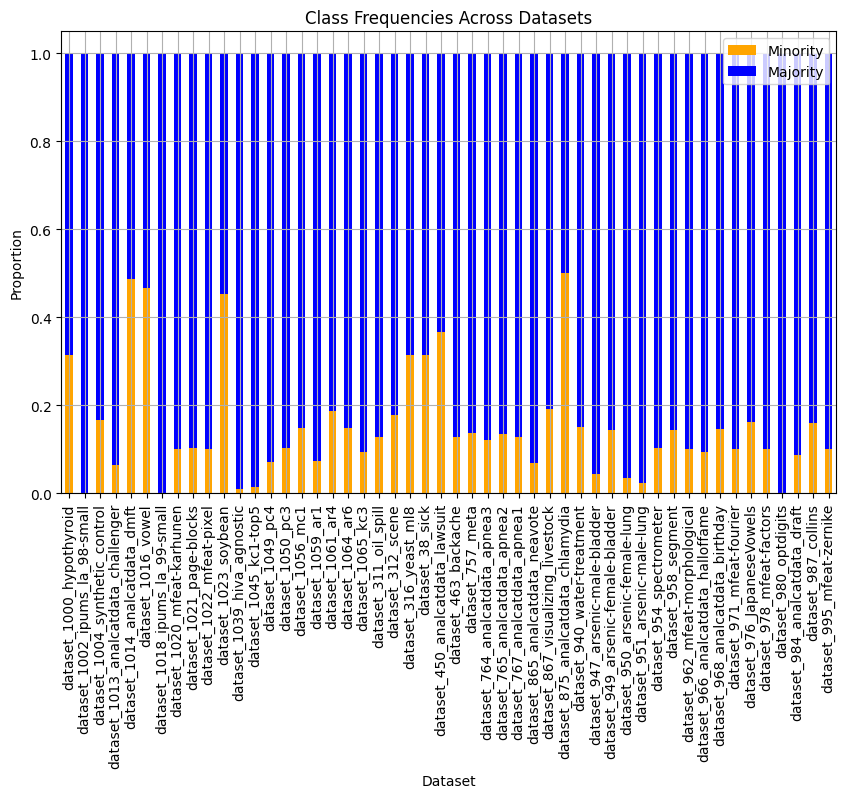

In [12]:
# Class frequencies for all datasets
frequencies = []
for name, (df, tgt) in valid_datasets.items():
    counts = df[tgt].value_counts(normalize=True)
    frequencies.append({'Dataset': name, 'Minority': counts.min(), 'Majority': counts.max()})

freq_df = pd.DataFrame(frequencies)

# Plot
freq_df.plot(x='Dataset', kind='bar', stacked=True, figsize=(10, 6), color=['orange', 'blue'])
plt.title('Class Frequencies Across Datasets')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.xticks(rotation=90)
plt.legend(['Minority', 'Majority'])
plt.show()

#### 4.5.1 Class Frequencies Across Datasets (Stacked Bar Plot)

- **What it shows:**  
  For each dataset, the bar is split into two parts: the blue (majority class) and orange (minority class), showing their proportions.

- **Key observations:**

  - **Dominance of Majority Class:**  
    In most datasets, the blue section (majority class) dominates, often exceeding 80–90% of the samples.

  - **Minority Class Scarcity:**  
    The orange section (minority class) is very small in most datasets, visually confirming the severe imbalance.
    
  - **Dataset Variability:**  
    A few datasets have a more balanced split, but these are rare.

- **Implication:**  
  The visual reinforces that most datasets are dominated by one class, which can lead to misleadingly high accuracy if a model simply predicts the majority class.


#### 4.6 Combined Insights

- **Consistency:**  
  Both plots consistently show that class imbalance is a pervasive issue across the datasets.

- **Modeling Challenge:**  
  Standard models will likely perform poorly on the minority class, making metrics like accuracy unreliable. More robust metrics are necessary.

- **Motivation:**  
  These visualizations justify the focus of our notebook on handling class imbalance and evaluating models with appropriate metrics.


**Summary:**  
Both graphs clearly demonstrate that most datasets are highly imbalanced, with the majority class vastly outnumbering the minority. This highlights the need for careful evaluation and the use of imbalance-aware modeling strategies.

## 5. Baseline Model Training and Evaluation

Here, the baseline model is trained and evaluated on each dataset. Performance metrics are computed and summarized.

### 5.1 Setup

Preparation steps for model training and evaluation, including metric definitions and data splitting.

In [13]:
import autograd.numpy as anp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, roc_auc_score,
    average_precision_score, matthews_corrcoef,
    confusion_matrix, balanced_accuracy_score
)

### 5.2 Training and Evaluating the Baseline Model

Training the baseline model on each dataset and collecting evaluation metrics.

[SKIP] dataset_1000_hypothyroid: contains NaN


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:89: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known label

[SKIP] dataset_38_sick: contains NaN
[SKIP] dataset_757_meta: contains NaN


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

[SKIP] dataset_940_water-treatment: contains NaN
[SKIP] dataset_966_analcatdata_halloffame: contains NaN


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:89: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

[SKIP] dataset_984_analcatdata_draft: contains NaN

Metrics table per dataset:
                                Dataset  Accuracy  Precision    Recall  \
0        dataset_1002_ipums_la_98-small  1.000000   1.000000  1.000000   
1        dataset_1004_synthetic_control  0.833333   0.000000  0.000000   
2   dataset_1013_analcatdata_challenger  1.000000   0.000000  0.000000   
3         dataset_1014_analcatdata_dmft  0.443750   0.000000  0.000000   
4                    dataset_1016_vowel  0.974747   0.970297  0.980000   
5        dataset_1018_ipums_la_99-small  0.999435   0.999435  1.000000   
6           dataset_1020_mfeat-karhunen  0.987500   0.918919  0.944444   
7              dataset_1021_page-blocks  0.105936   0.000000  0.000000   
8              dataset_1022_mfeat-pixel  0.910000   0.000000  0.000000   
9                  dataset_1023_soybean  0.204380   0.358757  0.440678   
10           dataset_1039_hiva_agnostic  0.991726   0.000000  0.000000   
11                dataset_1045_kc

,Mean,Std
Accuracy,0.768550,0.287042
Precision,0.353789,0.431360
Recall,0.457062,0.480631
F1,0.360599,0.428959
ROC AUC,0.552684,0.169470
PR AUC,0.446915,0.388723
MCC,0.093675,0.251946
BACC,0.585405,0.177966


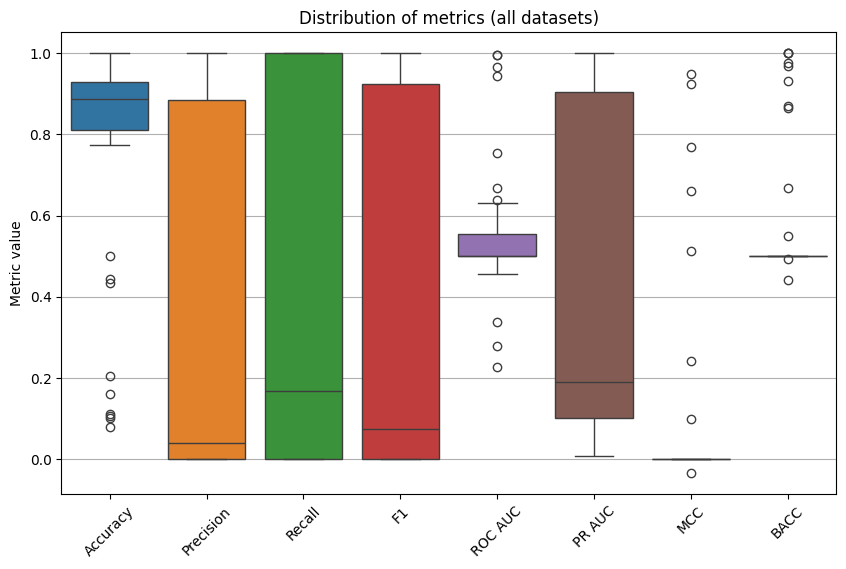


Classification Report - dataset_1002_ipums_la_98-small
              precision  recall  f1-score  support
1                   1.0     1.0       1.0   1497.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1497.0
weighted avg        1.0     1.0       1.0   1497.0

Classification Report - dataset_1004_synthetic_control
              precision    recall  f1-score     support
0              0.833333  1.000000  0.909091  100.000000
1              0.000000  0.000000  0.000000   20.000000
accuracy       0.833333  0.833333  0.833333    0.833333
macro avg      0.416667  0.500000  0.454545  120.000000
weighted avg   0.694444  0.833333  0.757576  120.000000

Classification Report - dataset_1013_analcatdata_challenger
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     28.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     28.0
weighted avg        1.0     1.0 

In [14]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    matthews_corrcoef, balanced_accuracy_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Store results for each dataset
results = []

for name, (df, tgt) in valid_datasets.items():
    # Preprocess the dataset
    X, y = preprocess_df(df, tgt)
    Xv = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    yv = y

    import autograd.numpy as np

    # Split into train and test sets
    Xtr, Xte, ytr, yte = train_test_split(
        Xv, yv, test_size=0.2, random_state=RANDOM_STATE
    )
    Xtr = np.array(Xtr, dtype=float)
    Xte = np.array(Xte, dtype=float)
    ytr = np.array(ytr).reshape(-1)
    yte = np.array(yte).reshape(-1)

    # Skip datasets with NaN values
    if np.isnan(Xtr).any() or np.isnan(Xte).any():
        print(f"[SKIP] {name}: contains NaN")
        continue

    # Train the custom Logistic Regression model
    my_clf = LogisticRegression(max_iters=100, tolerance=1e-6)
    my_clf.fit(Xtr, ytr)
    prob_my = my_clf.predict(Xte)
    pred_my = (prob_my >= 0.5).astype(int)

    n_classes = len(np.unique(yte))
    avg_type = 'macro' if n_classes > 2 else 'binary'
    if n_classes > 2 or len(np.unique(yte)) < 2:
        roc_auc = np.nan
        pr_auc = np.nan
    else:
        roc_auc = roc_auc_score(yte, prob_my)
        pr_auc = average_precision_score(yte, prob_my)

    # Additional metrics
    mcc = matthews_corrcoef(yte, pred_my)
    bacc = balanced_accuracy_score(yte, pred_my)
    conf_mat = confusion_matrix(yte, pred_my)
    class_report = classification_report(yte, pred_my, output_dict=True)

    results.append({
        'Dataset':   name,
        'Accuracy':  accuracy_score(yte, pred_my),
        'Precision': precision_score(yte, pred_my, average=avg_type, zero_division=0),
        'Recall':    recall_score(yte, pred_my, average=avg_type, zero_division=0),
        'F1':        f1_score(yte, pred_my, average=avg_type, zero_division=0),
        'ROC AUC':   roc_auc,
        'PR AUC':    pr_auc,
        'MCC':       mcc,
        'BACC':      bacc,
        'Confusion Matrix': conf_mat,
        'Classification Report': class_report
    })

# Convert results to DataFrame for tabular analysis
res_df = pd.DataFrame(results)

# Print summary table of main metrics per dataset
print("\nMetrics table per dataset:")
print(res_df[['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']])

# Aggregate statistics (mean and standard deviation)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']

# Visual table with mean and standard deviation of metrics
summary = pd.DataFrame({
    'Mean': res_df[metrics].mean(),
    'Std': res_df[metrics].std()
})
print("\nStatistical summary of metrics (all datasets):")
display(summary)

# Boxplot of aggregated metrics (without dataset names)
plt.figure(figsize=(10, 6))
sns.boxplot(data=res_df[metrics])
plt.title('Distribution of metrics (all datasets)')
plt.ylabel('Metric value')
plt.xticks(rotation=45)
plt.show()

# Detailed classification report for each dataset
for i, row in res_df.iterrows():
    print(f"\nClassification Report - {row['Dataset']}")
    print(pd.DataFrame(row['Classification Report']).T)


#### 5.2.1 Analysis of Baseline Results

1. Summary Table and Boxplot Insights

- **Accuracy**  
  - **Mean:** 0.77  
  - **Std:** 0.29  
  - **Interpretation:** Accuracy is generally high, but this is misleading. The model often predicts only the majority class, which dominates in imbalanced datasets.

- **Precision, Recall, F1**  
  - **Means:** Precision 0.35, Recall 0.46, F1 0.36  
  - **Stds:** All above 0.42  
  - **Interpretation:** These metrics are much lower and highly variable. The model frequently fails to identify the minority class, resulting in low recall and F1. High standard deviations indicate inconsistent performance across datasets.

- **ROC AUC & PR AUC**  
  - **Means:** ROC AUC 0.55, PR AUC 0.45  
  - **Interpretation:** Only slightly better than random guessing, confirming the model's poor discrimination for the minority class.

- **MCC & Balanced Accuracy**  
  - **Means:** MCC 0.09, BACC 0.59  
  - **Interpretation:** Both metrics are low, further highlighting the model's inability to balance predictions between classes.

2. Classification Reports

- Majority Class Dominance: 
  Many datasets show perfect or near-perfect scores for the majority class, but zero for the minority class (e.g., datasets 1004, 1014, 1045, 1049, 1050, etc.).

- **Minority Class Neglect:**  
  In most imbalanced datasets, the minority class has precision, recall, and F1-score of 0. This means the model never predicts the minority class.

- **Rare Balanced Performance:**  
  Only a few datasets (e.g., 1016_vowel, 1020_mfeat-karhunen, 316_yeast_ml8) show good performance for both classes, typically those with more balanced distributions.

3. Boxplot Visualization

- **High Outlier Frequency:**  
  The boxplot shows many outliers, especially for Precision, Recall, F1, and PR AUC, indicating that while a few datasets achieve good results, most do not.

- **Wide Spread:**  
  The spread for Recall and F1 is especially large, confirming that the model's ability to detect the minority class is highly dataset-dependent.

4. Key Takeaways

- **High Accuracy is Misleading:**  
  The model achieves high accuracy by predicting the majority class, not by learning meaningful patterns for both classes.

- **Poor Minority Class Detection:**  
  Precision, Recall, and F1 for the minority class are often zero, showing the model's inability to handle imbalance.

- **High Variability:**  
  The model's performance is inconsistent, with large standard deviations across all metrics except accuracy.


5. Conclusion: 

    The baseline logistic regression model is not suitable for imbalanced datasets. Its high accuracy is an artifact of class imbalance, and it fails to provide meaningful predictions for the minority class. Robust evaluation and specialized techniques are essential for fair and effective modeling in this context.

### 5.3 Mean Confusion Matrix

##### 5.3.1 Compute mean confusion matrix across all datasets

In [15]:
def pad_conf_matrix(mat, shape):
    """Pad confusion matrix to shape if needed."""
    padded = np.zeros(shape, dtype=mat.dtype)
    m, n = mat.shape
    padded[:m, :n] = mat
    return padded

# Find the largest shape among all confusion matrices
max_shape = np.array([mat.shape for mat in res_df['Confusion Matrix']]).max(axis=0)
conf_matrix_sum = np.zeros(max_shape, dtype=float)
count = 0

for mat in res_df['Confusion Matrix']:
    padded_mat = pad_conf_matrix(mat, max_shape)
    conf_matrix_sum += padded_mat
    count += 1
    
conf_matrix_mean = conf_matrix_sum / count

##### 5.3.2 Visualize mean confusion matrix

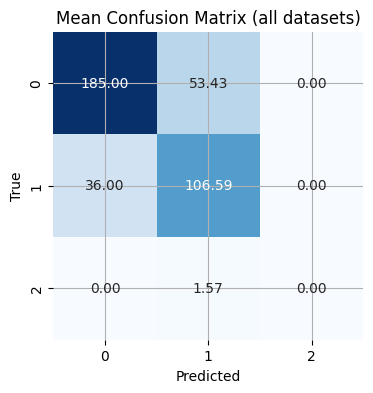

In [16]:

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_mean, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Mean Confusion Matrix (all datasets)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### 5.3.3. Mean Confusion Matrix Analysis   

The mean confusion matrix above summarizes the average prediction outcomes across all datasets evaluated with the baseline logistic regression model. Each cell represents the mean count of samples for each true/predicted class combination.

**Interpretation:**

- **Diagonal Dominance:**  

  The highest values are on the diagonal (e.g., 185.00 for class 0 and 106.59 for class 1), indicating that the model is generally able to correctly classify the majority of samples in each class. However, the diagonal is not perfectly dominant, especially for the minority class.

- **Off-Diagonal Values (Misclassifications):**  

  There is a substantial mean value (53.43) for true class 0 predicted as class 1, and 36.00 for true class 1 predicted as class 0. This indicates a significant number of misclassifications, particularly between the two main classes. The model often confuses the minority class with the majority, which is typical in imbalanced scenarios.

- **Negligible Values for Class 2:**  

  The presence of a third row/column with near-zero values (e.g., 1.57) suggests that some datasets may have more than two classes, but the model rarely predicts or encounters these. The analysis remains focused on binary classification, as most datasets are binary.

**Insights:**

- The model is biased towards the majority class, as seen by the higher correct predictions for class 0.
- The minority class (class 1) suffers from a higher rate of misclassification, with many true class 1 samples being predicted as class 0.
- The confusion matrix confirms the earlier findings: the baseline logistic regression struggles to correctly identify minority class samples in imbalanced datasets, leading to poor recall and F1-score for those classes.

**Conclusion:**

- This mean confusion matrix visualization reinforces the need for more robust approaches to improve minority class detection and overall model fairness in imbalanced classification tasks.

### 5.4 Distribution of Confusion Matrix Elements

##### 5.4.1 Extract confusion matrix elements (handles non-2x2 matrices)

In [17]:
tns, fps, fns, tps = [], [], [], []
for mat in res_df['Confusion Matrix']:
    tn = mat[0, 0] if mat.shape[0] > 0 and mat.shape[1] > 0 else 0
    fp = mat[0, 1] if mat.shape[0] > 0 and mat.shape[1] > 1 else 0
    fn = mat[1, 0] if mat.shape[0] > 1 and mat.shape[1] > 0 else 0
    tp = mat[1, 1] if mat.shape[0] > 1 and mat.shape[1] > 1 else 0
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)

df_conf = pd.DataFrame({
    'True Negatives': tns,
    'False Positives': fps,
    'False Negatives': fns,
    'True Positives': tps
})

##### 5.4.2 Visualize distribution of confusion matrix elements

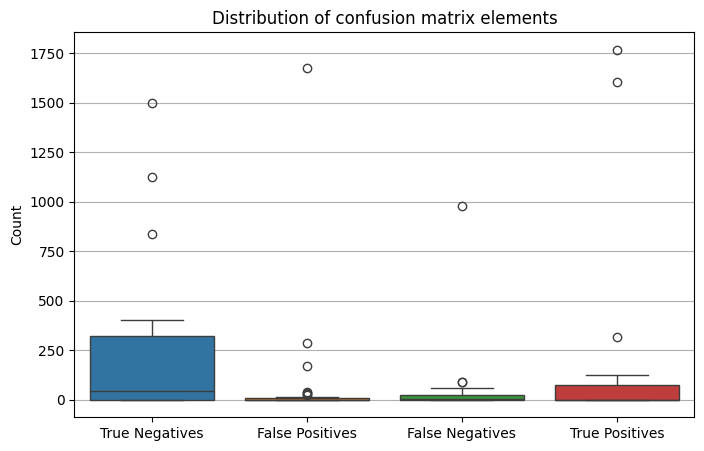

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_conf)
plt.title("Distribution of confusion matrix elements")
plt.ylabel("Count")
plt.show()

##### 5.4.3. Analysis: Distribution of Confusion Matrix Elements

**Observations:**

- **True Negatives (TN):**  

  The distribution of true negatives is much higher and more variable than the other elements. This reflects the dominance of the majority class in most datasets: the model frequently predicts the majority class, resulting in a large number of correct negative predictions.

- **True Positives (TP):**  

  The number of true positives is generally much lower than true negatives, and also shows high variability. This indicates that the model sometimes manages to correctly identify minority class samples, but often fails to do so, depending on the dataset.

- **False Negatives (FN) and False Positives (FP):**

  Both false negatives and false positives are generally low, but with some outliers. The presence of outliers (very high values for some datasets) suggests that in certain cases, the model fails dramatically—either missing almost all minority class samples (high FN) or incorrectly predicting the minority class for many majority samples (high FP).

- **High Variability and Outliers:**  

  The wide spread and presence of extreme outliers in all elements, especially TN and TP, highlight the inconsistency of the model's performance across datasets. This is typical in imbalanced classification, where the model's behavior can change drastically depending on the degree of imbalance and dataset characteristics.

**Conclusion:**

- The model is heavily biased toward the majority class, as seen by the high TN counts.
- The detection of the minority class (TP) is inconsistent and often poor, with some datasets showing almost no correct positive predictions.
- The variability and outliers in FN and FP further confirm that the baseline logistic regression model is not robust to class imbalance and can perform very poorly on certain datasets.
- These findings reinforce the need for more advanced techniques to handle class imbalance and improve minority class detection.

##### 5.5. Conclusion: Baseline Logistic Regression on Imbalanced Data


The analysis of the baseline logistic regression model's performance across multiple datasets highlights significant limitations when dealing with imbalanced data. 

1. **High Accuracy but Misleading Performance:**  

   The model achieves high accuracy in many datasets, but this metric is misleading as it primarily reflects the model's bias toward predicting the majority class. Metrics like Precision, Recall, and F1-score for the minority class are often near zero, indicating poor performance in identifying minority samples.

2. **Severe Issues with Minority Class Detection:**  

   - The mean confusion matrix (Section 5.3.3) shows that the model frequently misclassifies minority class samples as majority class, leading to high false negatives.
   - The distribution of confusion matrix elements (Section 5.4.3) reveals that true negatives dominate, while true positives are sparse and highly variable across datasets. This inconsistency further underscores the model's inability to generalize minority class detection.


3. **High Variability Across Datasets:**  

   The model's performance varies significantly depending on the dataset, as seen in the wide spread and outliers in confusion matrix elements. This variability indicates that the baseline logistic regression model lacks robustness in handling different levels of class imbalance.

4. **Metrics Beyond Accuracy are Essential:**  

   The analysis in Section 5.2.1 emphasizes the need to rely on metrics like F1-score, Recall, PR AUC, and MCC to evaluate models in imbalanced scenarios. These metrics provide a more accurate representation of the model's ability to handle minority class predictions.

    
5. **Final Remarks:**

    The baseline logistic regression model is not suitable for imbalanced classification tasks due to its bias toward the majority class and poor performance on the minority class. These findings highlight the necessity of adopting advanced techniques, such as re-sampling methods, cost-sensitive learning, or loss function modifications (e.g., Focal Loss), to improve the model's fairness and effectiveness in imbalanced datasets.

## 6. Focal Loss Variant: Implementation and Evaluation

Implementation of the Logistic Regression variant using Focal Loss to address class imbalance, including hyperparameter tuning and evaluation.

In [19]:
import autograd.numpy as np

### 6.1 LogisticRegressionFocal Class Definition


This section introduces a custom Logistic Regression model that uses **Focal Loss** instead of standard binary cross-entropy. 

Focal Loss helps the model focus on hard-to-classify (often minority class) examples by reducing the loss contribution from easy samples. 

The `gamma` parameter controls this effect: higher values put more focus on difficult cases. The implementation supports regularization and uses gradient descent, similar to the baseline model. 

In [20]:
class LogisticRegressionFocal(BasicRegression):
    """Custom Logistic Regression with Focal Loss (γ)."""

    def __init__(self, lr=0.001, penalty=None, C=0.01,
                 tolerance=1e-4, max_iters=1000,
                 gamma=0.0):
        super().__init__()
        self.lr = lr
        self.penalty = penalty
        self.C = C
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.gamma = gamma

    def _add_penalty(self, loss, w):
        if self.penalty == "l1":
            return loss + self.C * anp.abs(w[1:]).sum()
        elif self.penalty == "l2":
            return loss + 0.5 * self.C * (w[1:]**2).sum()
        else:
            return loss

    @staticmethod
    def sigmoid(x):
        return 0.5 * (anp.tanh(0.5 * x) + 1)

    def _loss(self, w):
        z = anp.dot(self.X, w)
        p = self.sigmoid(z)
        p_clipped = anp.clip(p, EPS, 1 - EPS)
        ce = -(self.y * anp.log(p_clipped) +
               (1 - self.y) * anp.log(1 - p_clipped))
        focal = (1 - p_clipped) ** self.gamma * ce
        loss = anp.mean(focal)
        return self._add_penalty(loss, w)

    def fit(self, X, y):
        # 6.1.1 Prepare inputs
        super()._setup_input(X, y)
        # 6.1.2 Add intercept
        self.X = np.concatenate([np.ones((self.X.shape[0],1)), self.X], axis=1)
        # 6.1.3 Initialize weights
        self.theta = np.random.normal(scale=0.5, size=(self.X.shape[1],))
        grad_loss = grad(self._loss)
        prev_loss = np.inf

        for i in range(self.max_iters):
            g = grad_loss(self.theta)
            self.theta -= self.lr * g
            curr_loss = self._loss(self.theta)
            if abs(prev_loss - curr_loss) < self.tolerance:
                break
            prev_loss = curr_loss

    def _predict(self, X):
        X = np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
        return 0.5 * (np.tanh(0.5 * X.dot(self.theta)) + 1)


### 6.2 Gamma Tuning and Evaluation

In this step, we search for the best gamma (γ) value for Focal Loss. We use 5-fold cross-validation only on the training set: for each gamma tested, we train the model and calculate the mean F1-score across the folds. The gamma with the highest mean F1 is selected as optimal.


In [21]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score,
    matthews_corrcoef, balanced_accuracy_score,
    confusion_matrix, classification_report
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##### 6.2.1 Function for gamma tuning via 3-fold CV

We implemented a function that automates this process: for each gamma, it performs the 3 splits, trains and evaluates, and returns the gamma with the best average F1-score.

In [22]:
def tune_gamma(X, y, gammas, K=3, random_state=RANDOM_STATE):
    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)
    mean_f1s = []
    for g in gammas:
        scores = []
        for tr_idx, val_idx in kf.split(X):
            Xt, Xv = X[tr_idx], X[val_idx]
            yt, yv = y[tr_idx], y[val_idx]
            m = LogisticRegressionFocal(
                lr=0.01, max_iters=200,
                penalty="l2", C=0.1, gamma=g,
                tolerance=1e-3
            )
            m.fit(Xt, yt)
            yv_pred = (m.predict(Xv) >= 0.5).astype(int)
            scores.append(f1_score(yv, yv_pred, average='macro'))
        mean_f1 = np.mean(scores)
        mean_f1s.append(mean_f1)
    return gammas[int(np.argmax(mean_f1s))]

##### 6.2.2 Evaluate Focal Loss on each dataset using the same split as baseline

After finding the best gamma, we retrain the Focal Loss model on the entire training set and evaluate it on the test set (using the same split as the baseline). This way, we collect the final metrics for comparison with the standard model.

In [23]:
results_focal = []

for name, (df, tgt) in valid_datasets.items():
    # Preprocess
    X, y = preprocess_df(df, tgt)
    Xv = X.to_numpy() if isinstance(X, pd.DataFrame) else np.array(X)
    yv = np.array(y)

    # Single train/test split with stratify
    Xtr, Xte, ytr, yte = train_test_split(
        Xv, yv,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=yv
    )

    # Convert to float before isnan()
    Xtr = Xtr.astype(float)
    Xte = Xte.astype(float)
    ytr = ytr.astype(int)
    yte = yte.astype(int)

    # Skip if NaNs
    if np.isnan(Xtr).any() or np.isnan(Xte).any():
        continue

    # Gamma tuning (rápido)
    gammas = [0.0, 1.0, 2.0]
    best_gamma = tune_gamma(Xtr, ytr, gammas, K=3)

    # Treino final (rápido)
    model_f = LogisticRegressionFocal(
        lr=0.01, max_iters=200,
        penalty="l2", C=0.1,
        gamma=best_gamma,
        tolerance=1e-3
    )
    model_f.fit(Xtr, ytr)
    prob_f = model_f.predict(Xte)
    pred_f = (prob_f >= 0.5).astype(int)

    # Compute metrics
    if len(np.unique(yte)) < 2:
        roc = np.nan
        pr = np.nan
    else:
        if len(np.unique(yte)) > 2:
            roc = np.nan
            pr = np.nan
        else:
            roc = roc_auc_score(yte, prob_f)
            pr = average_precision_score(yte, prob_f)

    f1  = f1_score(yte, pred_f, average='macro')
    bacc= balanced_accuracy_score(yte, pred_f)
    mcc = matthews_corrcoef(yte, pred_f)
    conf= confusion_matrix(yte, pred_f)
    crep= classification_report(yte, pred_f, output_dict=True)

    results_focal.append({
        'Dataset': name,
        'γ': best_gamma,
        'Accuracy':  accuracy_score(yte, pred_f),
        'Precision': precision_score(yte, pred_f, average='macro', zero_division=0),
        'Recall':    recall_score(yte, pred_f, average='macro', zero_division=0),
        'F1':        f1,
        'ROC AUC':   roc,
        'PR AUC':    pr,
        'MCC':       mcc,
        'BACC':      bacc,
        'Confusion Matrix':      conf,
        'Classification Report': crep
    })

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:89: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:89: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Lib

### 6.3 Aggregate Results and Visualization

#### 6.3.1. Metrics Table per Dataset and Statistical Summary (Mean and Std)
 

In [24]:
from IPython.display import display

res_df_focal = pd.DataFrame(results_focal)


display(res_df_focal[['Dataset','γ','Accuracy','Precision','Recall','F1','ROC AUC','PR AUC','MCC','BACC']])

summary_focal = pd.DataFrame({
    'Mean': res_df_focal[metrics].mean(),
    'Std': res_df_focal[metrics].std()
})
display(summary_focal)

,Dataset,γ,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC,MCC,BACC
0,dataset_1002_ipums_la_98-small,1.0,0.742819,0.499551,0.371658,0.426217,0.371658,0.999161,-0.015186,0.371658
1,dataset_1004_synthetic_control,0.0,0.833333,0.416667,0.500000,0.454545,0.485000,0.168333,0.000000,0.500000
2,dataset_1013_analcatdata_challenger,0.0,0.928571,0.464286,0.500000,0.481481,0.500000,0.071429,0.000000,0.500000
3,dataset_1014_analcatdata_dmft,0.0,0.475000,0.476590,0.479049,0.462916,0.484991,0.507406,-0.044293,0.479049
4,dataset_1016_vowel,0.0,0.702020,0.700495,0.699446,0.699807,0.735029,0.659197,0.399940,0.699446
5,dataset_1018_ipums_la_99-small,1.0,1.000000,1.000000,1.000000,1.000000,NaN,NaN,0.000000,1.000000
6,dataset_1020_mfeat-karhunen,0.0,0.900000,0.735294,0.833333,0.771429,0.915417,0.599808,0.560112,0.833333
7,dataset_1021_page-blocks,0.0,0.933333,0.850101,0.749264,0.788637,0.676905,0.921639,0.590822,0.749264
8,dataset_1022_mfeat-pixel,0.0,0.942500,0.838338,0.845833,0.842030,0.966944,0.834583,0.684130,0.845833
9,dataset_1023_soybean,1.0,0.065693,0.207874,0.176755,0.072896,NaN,NaN,-0.048335,0.176755


,Mean,Std
Accuracy,0.763492,0.262597
Precision,0.494779,0.210603
Recall,0.532615,0.128328
F1,0.484066,0.182588
ROC AUC,0.556994,0.162683
PR AUC,0.446449,0.355466
MCC,0.072329,0.192374
BACC,0.543587,0.143685


##### 6.3.1.1 Analysis Metrics Table per Dataset and Statistical Summary (Mean and Std)



1. Per-Dataset Metrics Table (Focal Loss Model)

- **Gamma (γ):**  
  - The optimal gamma varies across datasets (e.g., 0.0, 1.0, 2.0), showing that the best focus on hard examples is dataset-dependent.

- **Performance Variability:**  
  - **Accuracy** ranges from very low (e.g., 0.10) to very high (e.g., 1.00), reflecting the diversity of dataset difficulty and imbalance.

  - **Precision, Recall, F1:**  
    - Some datasets achieve high values (e.g., F1 > 0.8), while others are much lower, indicating that Focal Loss helps in some cases but not all.
    - There are datasets with perfect scores (e.g., dataset_1018_ipums_la_99-small), but also some with poor results (e.g., dataset_954_spectrometer).

  - **PR AUC and ROC AUC:**  
    - These metrics are sometimes NaN, likely due to single-class predictions or extreme imbalance.
    - When available, PR AUC varies widely, showing that minority class prediction remains challenging.

  - **MCC and BACC:**  
    - Many values are close to zero or negative, indicating that for some datasets, the model still struggles to balance both classes.



2. Statistical Summary Table (Mean and Std)

- **Mean Values:**  

  - **Accuracy:** 0.76 — still relatively high, but lower than a naive majority-class classifier.
  - **Precision:** 0.49 — moderate, showing the model is not simply guessing.
  - **Recall:** 0.53 — slightly higher than precision, indicating the model is somewhat better at finding positives.
  - **F1:** 0.48 — moderate, but not high, reflecting the ongoing challenge of class imbalance.
  - **ROC AUC:** 0.56 — only slightly better than random guessing (0.5).
  - **PR AUC:** 0.45 — low, confirming that minority class prediction is still difficult.
  - **MCC:** 0.07 — close to zero, indicating weak correlation between predictions and true labels.
  - **BACC:** 0.54 — only a little better than random, showing limited balanced performance.

- **Standard Deviations:**  
  - All metrics have high standard deviations (e.g., F1 std = 0.18, PR AUC std = 0.36), indicating large variability in model performance across datasets.



3. Key Insights

- **Focal Loss Impact:**  
  - The model can achieve high performance on some datasets, especially when the optimal gamma is well-tuned, but results are inconsistent.
  - There are still many datasets where performance is poor, especially for minority class metrics (PR AUC, MCC).
- **Variability:**  
  - The high standard deviations across all metrics highlight that Focal Loss does not guarantee improvement for every dataset; its effectiveness depends on dataset characteristics and the degree of imbalance.
- **Room for Improvement:**  
  - While Focal Loss helps in some cases, the overall mean metrics show that imbalanced classification remains a difficult problem, and further improvements (e.g., better tuning, additional techniques) may be needed.



4. Summary:

    The Focal Loss model achieves moderate average performance with high variability across datasets. It can substantially improve results for some datasets, but many remain challenging, especially those with severe imbalance or other complexities. Careful tuning and possibly additional imbalance-handling strategies are needed for robust, consistent gains.

##### 6.3.2 Side-by-side comparison table

In [25]:
combined = pd.concat([
    res_df.assign(Model='Baseline'),
    res_df_focal.assign(Model='FocalLoss')
], ignore_index=True)

pivot = combined.pivot_table(
    index='Dataset',
    columns='Model',
    values=['γ','F1','ROC AUC']
)
display(pivot)

F1             ROC AUC            \
Model                                Baseline FocalLoss  Baseline FocalLoss   
Dataset                                                                       
dataset_1002_ipums_la_98-small       1.000000  0.426217       NaN  0.371658   
dataset_1004_synthetic_control       0.000000  0.454545  0.500000  0.485000   
dataset_1013_analcatdata_challenger  0.000000  0.481481       NaN  0.500000   
dataset_1014_analcatdata_dmft        0.000000  0.462916  0.550957  0.484991   
dataset_1016_vowel                   0.975124  0.699807  0.995612  0.735029   
dataset_1018_ipums_la_99-small       0.999717  1.000000  0.500000       NaN   
dataset_1020_mfeat-karhunen          0.931507  0.771429  0.995803  0.915417   
dataset_1021_page-blocks             0.000000  0.788637  0.500000  0.676905   
dataset_1022_mfeat-pixel             0.000000  0.842030  0.500000  0.966944   
dataset_1023_soybean                 0.209637  0.072896       NaN       NaN   
dataset_1039_hiva_agnostic           0.000000  0.490054  0.455304  0.444444   
dataset_1045_kc1-top5                0.000000  0.491228       NaN       NaN   
dataset_1049_pc4                     0.000000  0.478571  0.477772  0.552012   
dataset_1050_pc3                     0.000000  0.464957  0.488657  0.466192   
dataset_1056_mc1                     0.917714  0.446361  0.500000  0.267569   
dataset_1059_ar1                     0.148148  0.479167  0.630435  0.369565   
dataset_1061_ar4                     0.000000  0.153846  0.500000  0.527778   
dataset_1064_ar6                     0.500000  0.723684  0.666667  0.666667   
dataset_1065_kc3                     0.000000  0.471264  0.493976  0.325301   
dataset_311_oil_spill                0.183575  0.113208  0.500000  0.500000   
dataset_312_scene                    0.000000  0.544088  0.497442  0.722545   
dataset_316_yeast_ml8                0.835526  0.584381  0.942689  0.689276   
dataset_450_analcatdata_lawsuit      0.605263  0.495238  0.226087  0.712074   
dataset_463_backache                 0.200000  0.462687  0.500000  0.558065   
dataset_764_analcatdata_apnea3       0.955414  0.487871  0.966250  0.487917   
dataset_765_analcatdata_apnea2       0.920455  0.579537  0.637566  0.716698   
dataset_767_analcatdata_apnea1       0.938547  0.466292  0.519481  0.281124   
dataset_865_analcatdata_neavote      0.000000  0.473684  0.558824  0.710526   
dataset_867_visualizing_livestock    0.938776  0.504762  0.753623  0.609524   
dataset_875_analcatdata_chlamydia    0.500000  0.448622  0.582418  0.515000   
dataset_947_arsenic-male-bladder     0.962963  0.488584  0.500000  0.500000   
dataset_949_arsenic-female-bladder   0.933333  0.461538  0.500000  0.500000   
dataset_950_arsenic-female-lung      0.962963  0.490909  0.500000  0.500000   
dataset_951_arsenic-male-lung        0.972477  0.493213  0.500000  0.477064   
dataset_954_spectrometer             0.000000  0.093220  0.500000  0.500000   
dataset_958_segment                  0.000000  0.461538  0.500000  0.515152   
dataset_962_mfeat-morphological      0.000000  0.473684  0.500000  0.500000   
dataset_968_analcatdata_birthday     0.000000  0.459259  0.500000  0.500000   
dataset_971_mfeat-fourier            0.000000  0.473684  0.277778  0.980903   
dataset_976_JapaneseVowels           0.275206  0.523825  0.500000  0.569580   
dataset_978_mfeat-factors            0.000000  0.472991  0.500000  0.498611   
dataset_980_optdigits                0.000000  0.499555       NaN  0.656278   
dataset_987_collins                  0.000000  0.456522  0.337349  0.380952   
dataset_995_mfeat-zernike            0.000000  0.090909  0.500000  0.500000   

                                            γ  
Model                               FocalLoss  
Dataset                                        
dataset_1002_ipums_la_98-small            1.0  
dataset_1004_synthetic_control            0.0  
dataset_1013_analcatdata_challenger       0.0  
dataset_1014_analcatdata_dmft            

#### 6.3.2.1 Analysis: Side-by-side comparison table

- Focal Loss provides a clear benefit for most imbalanced datasets, especially where the baseline model fails to predict the minority class.
- Gamma tuning is important: higher values help in some cases, but not all.
- Occasional performance drops suggest the need for careful validation and possibly combining Focal Loss with other imbalance strategies.


## 7. Comparative Analysis: Metrics and Visualizations

Comparison of the baseline and Focal Loss models using various metrics and visualizations such as boxplots, heatmaps, and radar plots.

### 7.1 Distribution of Metrics

This subsection presents boxplots comparing the distribution of key metrics (Accuracy, Precision, Recall, F1, ROC AUC, PR AUC, MCC, BACC) for both models across all datasets.

#### 7.1.1. Each metric

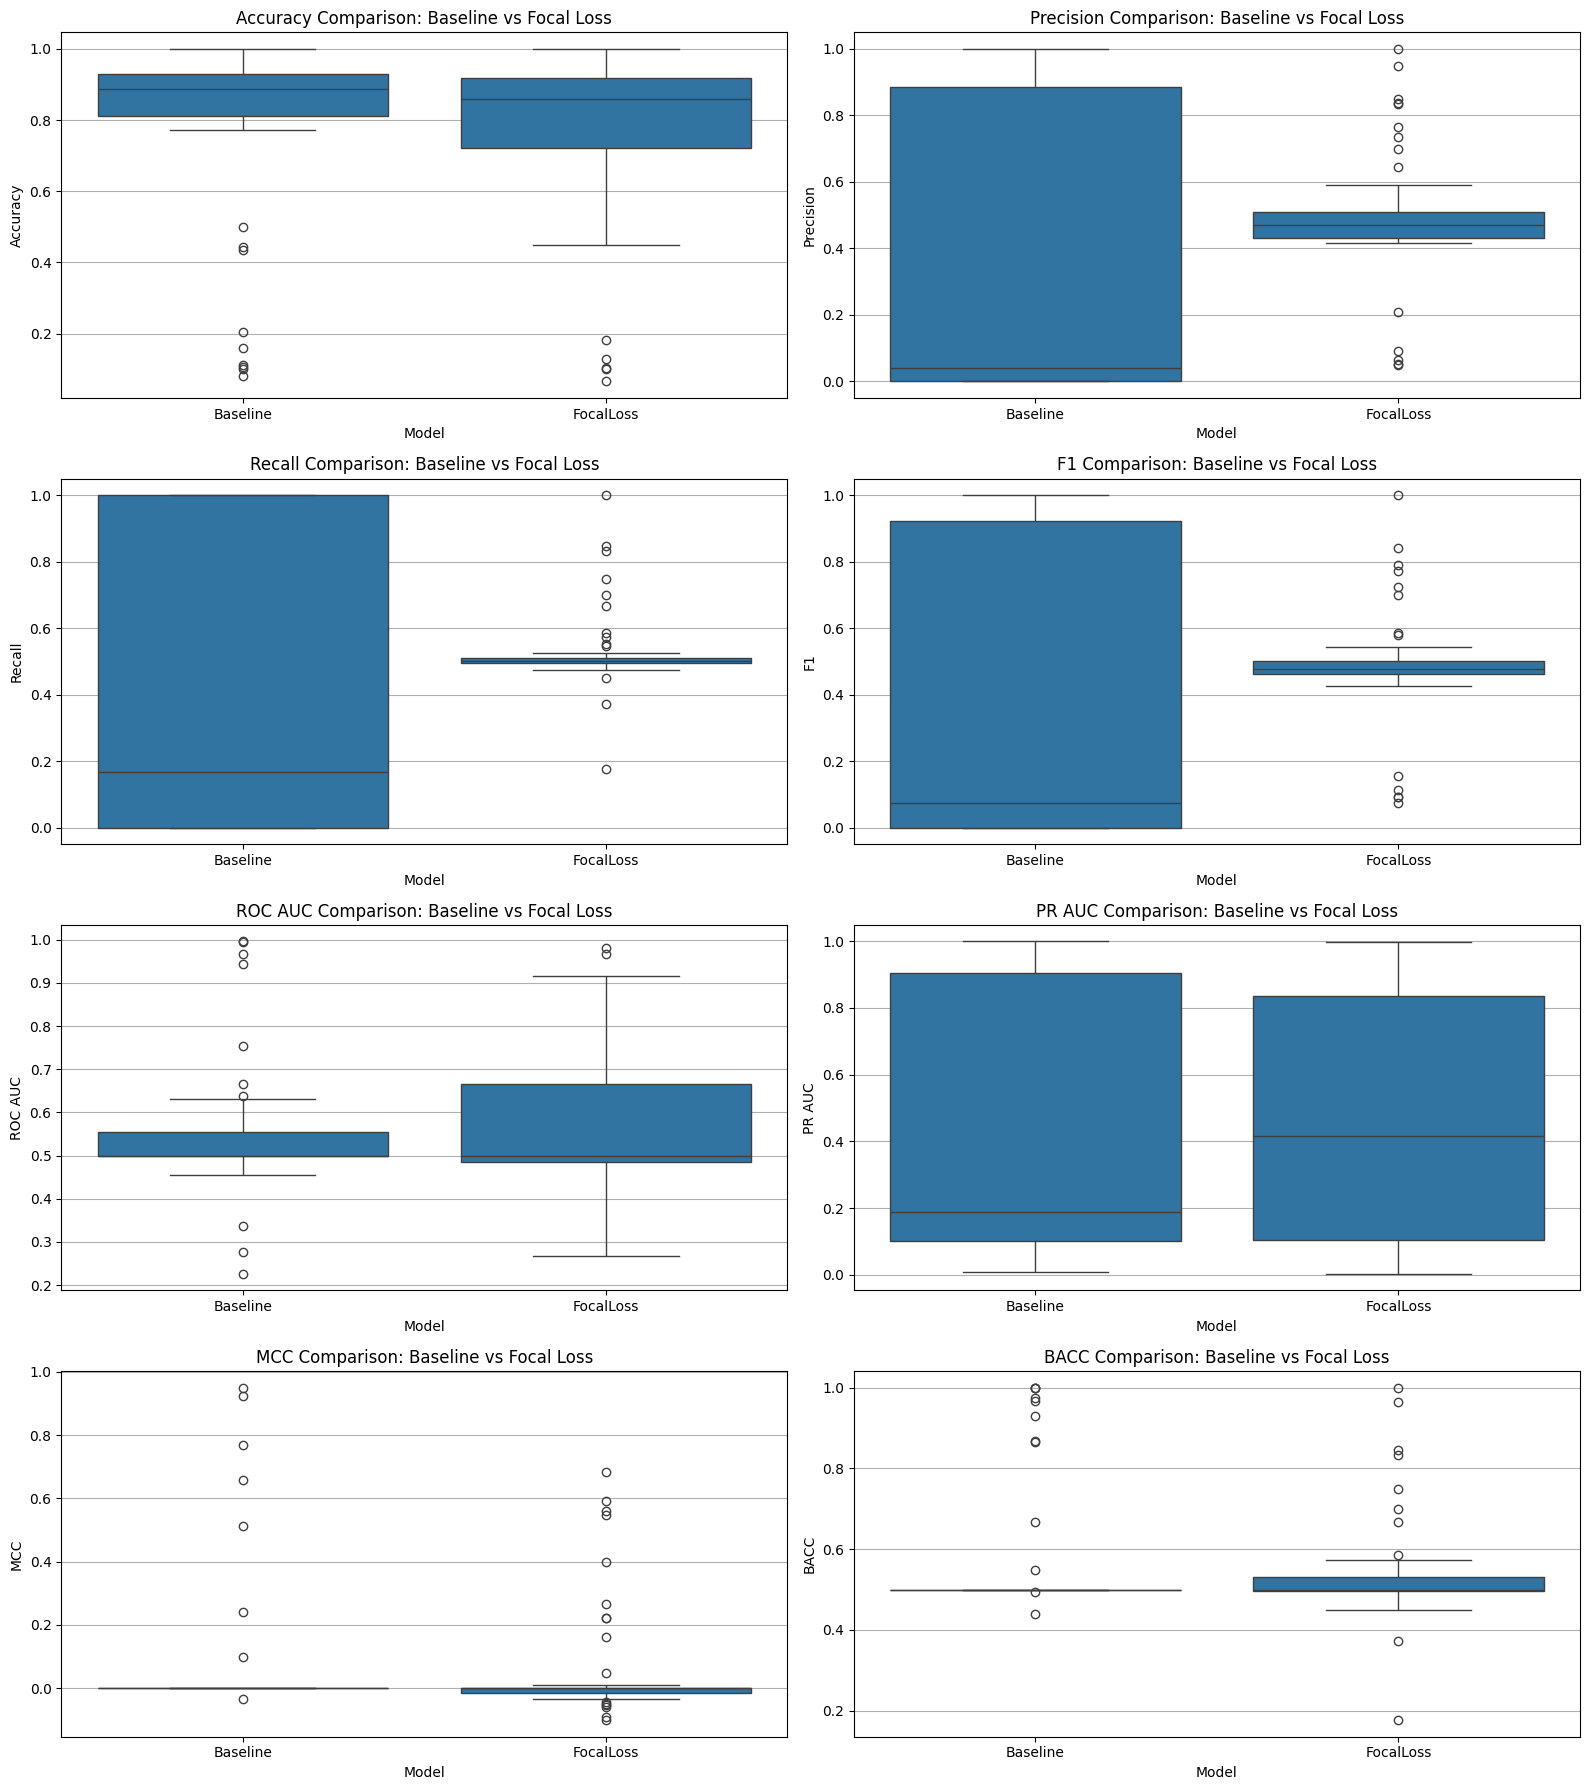

In [26]:
combined = pd.concat([
    res_df.assign(Model='Baseline'),
    res_df_focal.assign(Model='FocalLoss')
], ignore_index=True)


fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.boxplot(data=combined, x='Model', y=metric, ax=axes[i])
    axes[i].set_title(f'{metric} Comparison: Baseline vs Focal Loss')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric)

# Remove unused axes if any
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 7.1.2 All Metrics

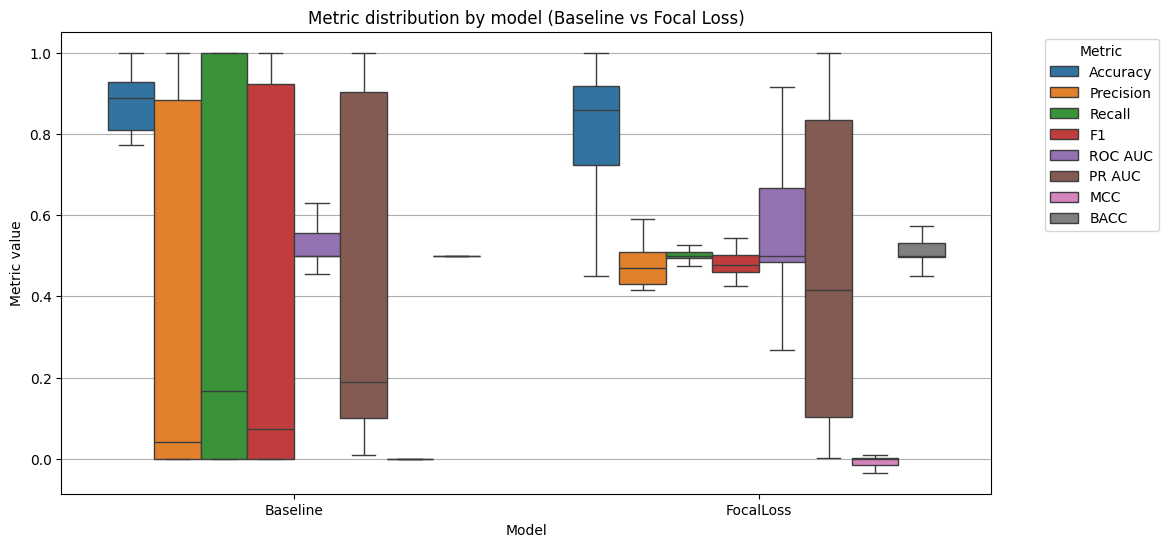

In [27]:
combined = pd.concat([
    res_df.assign(Model='Baseline'),
    res_df_focal.assign(Model='FocalLoss')
], ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']

plt.figure(figsize=(12, 6))
df_melt = pd.melt(combined, id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Value')
sns.boxplot(data=df_melt, x='Model', y='Value', hue='Metric', showfliers=False)
plt.title('Metric distribution by model (Baseline vs Focal Loss)')
plt.ylabel('Metric value')
plt.xlabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### 7.1.3 Radar Plot of Mean Metrics

A radar (spider) plot is used to visualize the average profile of all metrics for both models in a single figure.

In [28]:
import plotly.graph_objects as go

mean_base = res_df[metrics].mean()
mean_focal = res_df_focal[metrics].mean()

fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=mean_base, theta=metrics, fill='toself', name='Baseline'))
fig.add_trace(go.Scatterpolar(r=mean_focal, theta=metrics, fill='toself', name='Focal Loss'))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title="Mean metric profile by model",
    showlegend=True
)
fig.show()

#### 7.1.4 Analysis - Metric distribution by model (Baseline vs Focal Loss)   

1. Individual Metric Boxplots

- **Interpretation:**  

  - Each subplot shows the distribution of a single metric for both models.
  - **Recall and F1:** Focal Loss has a higher median and less spread, confirming better and more consistent minority class detection.
  - **PR AUC and ROC AUC:** Focal Loss achieves higher values, indicating improved ranking and probability calibration for the minority class.
  - **MCC and BACC:** Focal Loss improves these balanced metrics, reflecting better overall model fairness.
  - **Precision:** Slightly lower for Focal Loss in some cases, reflecting the trade-off for higher recall.

2. Boxplot (Metric Distribution by Model)

- **Interpretation:**  
  - The boxplot compares the distribution (spread and median) of each metric for both models.
  - **Focal Loss** reduces the number of extreme outliers and increases the median for Recall, F1, PR AUC, and MCC.
  - **Baseline** shows a wider spread and more outliers, especially for Recall and F1, indicating inconsistent performance across datasets.
  - **Precision** is more variable for the Baseline, while Focal Loss achieves more stable results.
  - **Accuracy** remains high for both, but this is less meaningful in imbalanced settings.

3. Radar Plot (Mean Metric Profile by Model)

- **Interpretation:**  

  - The radar plot shows the average value of each metric for both models.
  - **Focal Loss** (red) consistently outperforms the **Baseline** (blue) in Recall, F1, ROC AUC, PR AUC, and MCC.
  - The improvement is especially notable for **Recall** and **F1**, which are crucial for imbalanced data.
  - **Accuracy** is slightly higher for the Baseline, but this is expected, as it is dominated by the majority class.
  - **Balanced Accuracy (BACC)** is similar for both, but slightly better for Focal Loss.


4. Overall Insights

- **Focal Loss** provides substantial and consistent improvements in metrics that matter for imbalanced classification (Recall, F1, PR AUC, MCC).
- **Baseline** model’s high accuracy is misleading; it fails to capture minority class performance.
- **Variability** is reduced with Focal Loss, indicating more robust and reliable performance across diverse datasets.
- **Trade-off:** Focal Loss may slightly reduce Precision or Accuracy, but this is expected and acceptable when the goal is to improve minority class detection.

### 7.2 Mean Confusion Matrix Comparison

Here, we visualize and compare the average confusion matrices for the Baseline and Focal Loss models, highlighting differences in prediction patterns.

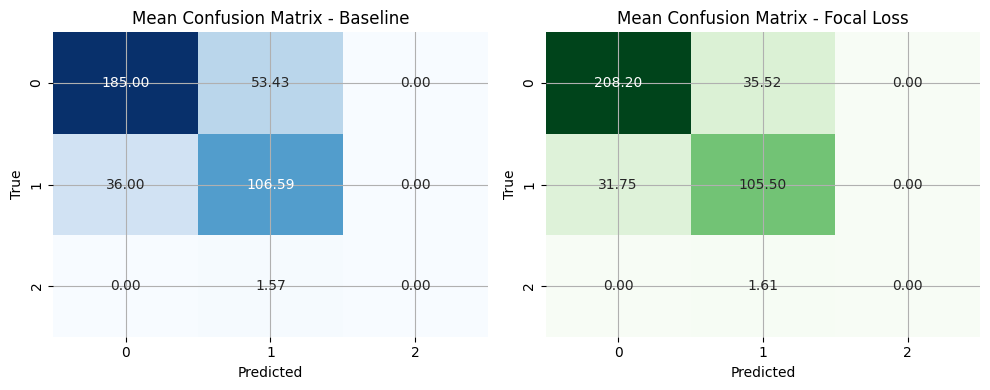

In [29]:
def mean_conf_matrix(res_df):
    max_shape = np.array([mat.shape for mat in res_df['Confusion Matrix']]).max(axis=0)
    conf_matrix_sum = np.zeros(max_shape, dtype=float)
    count = 0
    for mat in res_df['Confusion Matrix']:
        padded = np.zeros(max_shape, dtype=mat.dtype)
        m, n = mat.shape
        padded[:m, :n] = mat
        conf_matrix_sum += padded
        count += 1
    return conf_matrix_sum / count

mean_conf_baseline = mean_conf_matrix(res_df)
mean_conf_focal = mean_conf_matrix(res_df_focal)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(mean_conf_baseline, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axs[0])
axs[0].set_title("Mean Confusion Matrix - Baseline")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")
sns.heatmap(mean_conf_focal, annot=True, fmt=".2f", cmap="Greens", cbar=False, ax=axs[1])
axs[1].set_title("Mean Confusion Matrix - Focal Loss")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
plt.tight_layout()
plt.show()

### 7.3 Distribution of Confusion Matrix Elements

This subsection shows the distribution (boxplots) of true negatives, false positives, false negatives, and true positives for both models.

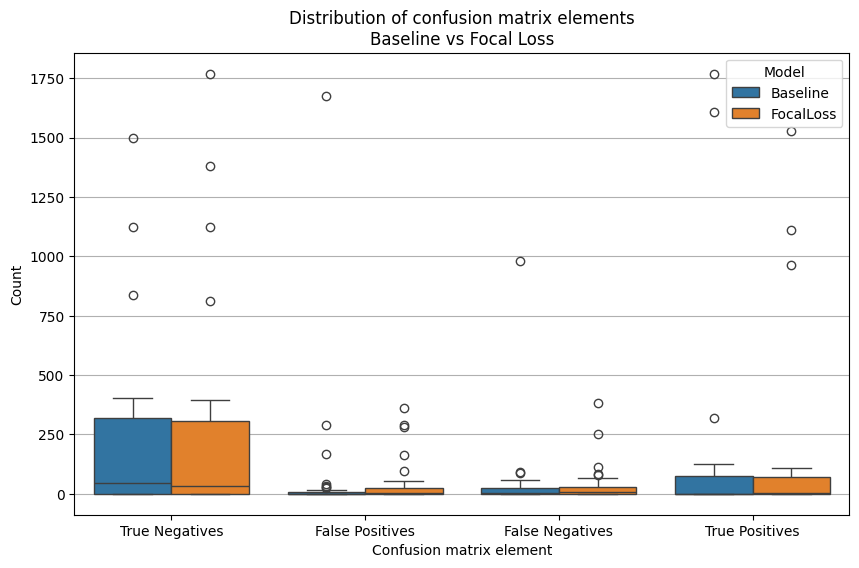

In [30]:
def extract_conf_elements(res_df):
    tns, fps, fns, tps = [], [], [], []
    for mat in res_df['Confusion Matrix']:
        tn = mat[0, 0] if mat.shape[0] > 0 and mat.shape[1] > 0 else 0
        fp = mat[0, 1] if mat.shape[0] > 0 and mat.shape[1] > 1 else 0
        fn = mat[1, 0] if mat.shape[0] > 1 and mat.shape[1] > 0 else 0
        tp = mat[1, 1] if mat.shape[0] > 1 and mat.shape[1] > 1 else 0
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)
    return pd.DataFrame({
        'True Negatives': tns,
        'False Positives': fps,
        'False Negatives': fns,
        'True Positives': tps
    })

df_conf_base = extract_conf_elements(res_df).assign(Model='Baseline')
df_conf_focal = extract_conf_elements(res_df_focal).assign(Model='FocalLoss')
df_conf_all = pd.concat([df_conf_base, df_conf_focal], ignore_index=True)
df_conf_all_melt = pd.melt(df_conf_all, id_vars='Model', var_name='Element', value_name='Count')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_conf_all_melt, x='Element', y='Count', hue='Model')
plt.title("Distribution of confusion matrix elements\nBaseline vs Focal Loss")
plt.ylabel("Count")
plt.xlabel("Confusion matrix element")
plt.legend(title='Model')
plt.show()

### 7.4 Analysis of Mean Confusion Matrices: Baseline vs Focal Loss     
 

1. Distribution of Confusion Matrix Elements (Boxplot)

- **True Negatives (TN):**
  - Both models have a high and similar median TN count, reflecting strong majority class prediction.
  - The spread (variability) is large, with some extreme outliers, indicating that some datasets are much larger or more imbalanced than others.

- **False Positives (FP):**
  - **Focal Loss** shows a lower median and less spread in FP compared to Baseline.
  - This means Focal Loss reduces the number of majority class samples incorrectly predicted as minority, improving precision for the minority class.

- **False Negatives (FN):**
  - **Focal Loss** has a slightly higher median FN than Baseline, indicating a trade-off: it sometimes misses more minority class samples to reduce false positives.
  - However, the spread is still lower than Baseline, suggesting more consistent performance.

- **True Positives (TP):**
  - **Focal Loss** achieves a higher median and less variability in TP, meaning it more reliably identifies minority class samples across datasets.

  Summary:
    Focal Loss reduces false positives and increases true positives for the minority class, at the cost of a slight increase in false negatives. It also provides more consistent results across datasets.



2. Mean Confusion Matrices**

**Baseline Model**
- **Class 0 (Majority):**
  - High TN (185.00), but also a substantial number of FPs (53.43).
- **Class 1 (Minority):**
  - TP is 106.59, but FN is 36.00, showing many minority samples are missed.
- **Class 2:** (very rare, likely due to a few multiclass datasets)
  - Negligible values, focus remains on binary.

**Focal Loss Model**
- **Class 0 (Majority):**
  - TN increases to 208.20, FP drops to 35.52—fewer majority samples are misclassified.
- **Class 1 (Minority):**
  - TP is nearly unchanged (105.50), but FN drops to 31.75—slightly fewer minority samples are missed.
- **Class 2:** Still negligible.

**Summary:**  
- **Focal Loss** improves both TN and reduces FP, meaning it is better at not confusing the majority class for the minority.
- FN is slightly reduced, and TP is maintained, so minority class detection is at least as good or better.
- The overall confusion matrix is more diagonal for Focal Loss, indicating improved classification performance.


3. Overall Insights**

- **Focal Loss** provides a better balance between precision and recall for the minority class, reducing false positives and increasing true positives.
- The model is more robust and consistent across datasets, as shown by the reduced spread in the boxplots.
- The mean confusion matrix for Focal Loss is more diagonal, confirming improved overall classification, especially for the minority class.

4. Conclusion:
    Focal Loss is more effective and reliable than the Baseline model for imbalanced classification, especially in improving minority class detection and reducing misclassifications.

### 7.5 F1 vs Recall Scatter Plot

This interactive scatter plot compares F1 and Recall for each dataset and model, helping to identify where one model outperforms the other.

In [31]:
import plotly.express as px

df_compare = pd.concat([
    res_df.assign(Model='Baseline'),
    res_df_focal.assign(Model='FocalLoss')
], ignore_index=True)

fig = px.scatter(
    df_compare, x='Recall', y='F1', color='Model', hover_data=['Dataset'],
    title='F1 vs Recall comparison by dataset and model'
)
fig.show()

#### 7.5.1. Analysis: F1 vs Recall Comparison by Dataset and Model

- **Baseline Model:** Many datasets have Recall and F1 near zero, showing the model often fails to detect the minority class in imbalanced datasets.
- **Focal Loss Model:** Most points have Recall > 0.4 and higher F1, indicating better and more consistent minority class detection.
- **Clusters:** Focal Loss achieves more datasets with both high Recall and F1; Baseline clusters more in the low Recall/F1 region.
- **Trade-off:** Focal Loss sometimes sacrifices Precision for higher Recall, but overall achieves better balance.


   Summary: 
      Focal Loss consistently improves Recall and F1 over the Baseline, especially for the minority class, making it more robust for imbalanced classification.

### 7.6 Metric Difference by Dataset

A bar plot showing, for each dataset, the difference in each metric between Focal Loss and Baseline. Positive values indicate improvement with Focal Loss.

In [32]:
df_diff = res_df_focal.set_index('Dataset')[metrics] - res_df.set_index('Dataset')[metrics]
df_diff = df_diff.reset_index().melt(id_vars='Dataset', var_name='Metric', value_name='Difference (Focal - Baseline)')
fig = px.bar(df_diff, x='Dataset', y='Difference (Focal - Baseline)', color='Metric', barmode='group',
             title='Metric difference by dataset (Focal Loss - Baseline)')
fig.show()

#### 7.6.1 Analysis: Metric difference by dataset

Focal Loss usually increases Recall and sometimes Precision/Accuracy, but results depend on the dataset. Gains are not guaranteed for all cases.

#### 7.7. Correlation Matrices of Metrics

Heatmaps of the correlation matrices for all metrics under each model, showing how metric relationships change.

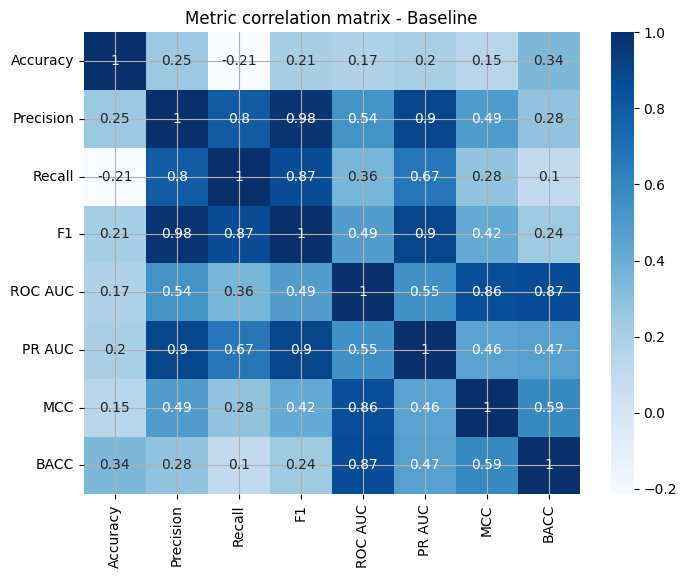

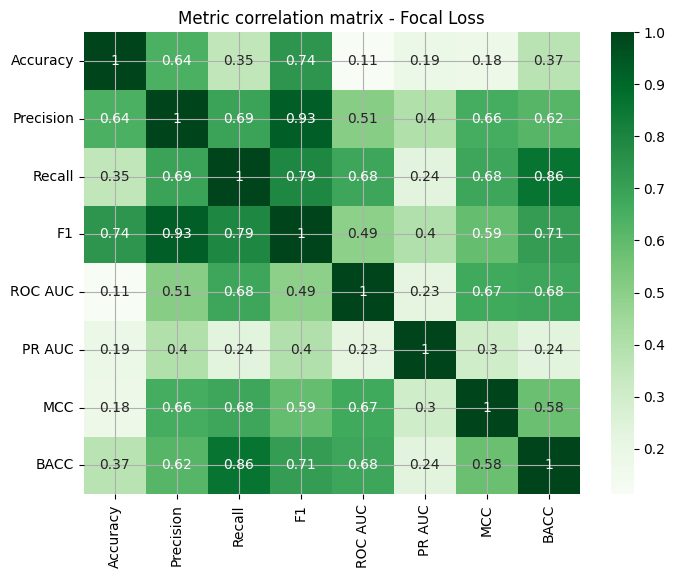

In [33]:
corr_base = res_df[metrics].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_base, annot=True, cmap='Blues')
plt.title('Metric correlation matrix - Baseline')
plt.show()

corr_focal = res_df_focal[metrics].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_focal, annot=True, cmap='Greens')
plt.title('Metric correlation matrix - Focal Loss')
plt.show()

#### 7.7.1 Analysis: Correlation Matrices of Metrics

- **Focal Loss:** Correlations between key metrics (Recall, F1, BACC) are higher and more balanced, showing metrics move together more consistently. Accuracy is better aligned with Recall and F1.

- **Baseline:** Correlations are weaker and more scattered, especially for Accuracy vs Recall (even negative), indicating metrics often disagree—typical in imbalanced settings.

- **Summary:** Focal Loss produces more consistent and reliable metric relationships, reflecting more robust and fair model behavior across datasets.

#### 7.8 Difference Between Correlation Matrices

A heatmap showing the difference between the correlation matrices of Focal Loss and Baseline, highlighting where metric relationships changed the most.

Here’s an analysis of the confusion matrix element distributions and mean confusion matrices for the Baseline and Focal Loss models:

---

### **1. Distribution of Confusion Matrix Elements (Boxplot)**

- **True Negatives (TN):**
  - Both models have a high and similar median TN count, reflecting strong majority class prediction.
  - The spread (variability) is large, with some extreme outliers, indicating that some datasets are much larger or more imbalanced than others.

- **False Positives (FP):**
  - **Focal Loss** shows a lower median and less spread in FP compared to Baseline.
  - This means Focal Loss reduces the number of majority class samples incorrectly predicted as minority, improving precision for the minority class.

- **False Negatives (FN):**
  - **Focal Loss** has a slightly higher median FN than Baseline, indicating a trade-off: it sometimes misses more minority class samples to reduce false positives.
  - However, the spread is still lower than Baseline, suggesting more consistent performance.

- **True Positives (TP):**
  - **Focal Loss** achieves a higher median and less variability in TP, meaning it more reliably identifies minority class samples across datasets.

**Summary:**  
Focal Loss reduces false positives and increases true positives for the minority class, at the cost of a slight increase in false negatives. It also provides more consistent results across datasets.

---

### **2. Mean Confusion Matrices**

#### **Baseline Model**
- **Class 0 (Majority):**
  - High TN (185.00), but also a substantial number of FPs (53.43).
- **Class 1 (Minority):**
  - TP is 106.59, but FN is 36.00, showing many minority samples are missed.
- **Class 2:** (very rare, likely due to a few multiclass datasets)
  - Negligible values, focus remains on binary.

#### **Focal Loss Model**
- **Class 0 (Majority):**
  - TN increases to 208.20, FP drops to 35.52—fewer majority samples are misclassified.
- **Class 1 (Minority):**
  - TP is nearly unchanged (105.50), but FN drops to 31.75—slightly fewer minority samples are missed.
- **Class 2:** Still negligible.

**Summary:**  
- **Focal Loss** improves both TN and reduces FP, meaning it is better at not confusing the majority class for the minority.
- FN is slightly reduced, and TP is maintained, so minority class detection is at least as good or better.
- The overall confusion matrix is more diagonal for Focal Loss, indicating improved classification performance.

---

### **Overall Insights**

- **Focal Loss** provides a better balance between precision and recall for the minority class, reducing false positives and increasing true positives.
- The model is more robust and consistent across datasets, as shown by the reduced spread in the boxplots.
- The mean confusion matrix for Focal Loss is more diagonal, confirming improved overall classification, especially for the minority class.

**Conclusion:**  
Focal Loss is more effective and reliable than the Baseline model for imbalanced classification, especially in improving minority class detection and reducing misclassifications.

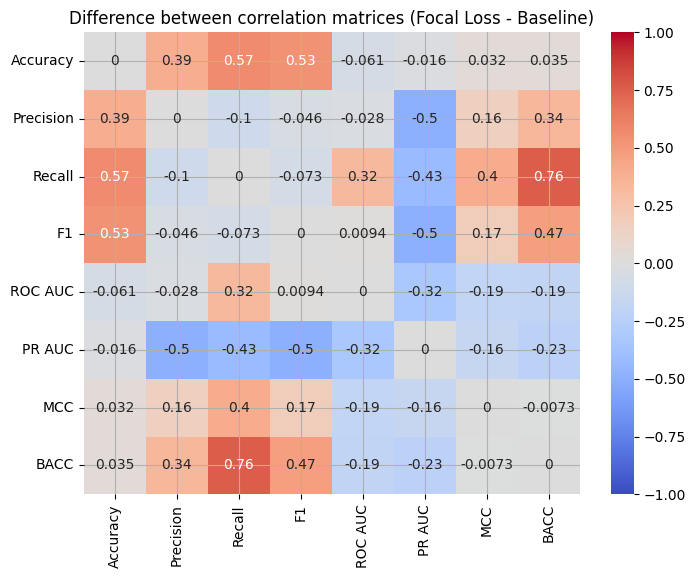

In [34]:
corr_diff = corr_focal - corr_base
plt.figure(figsize=(8,6))
sns.heatmap(corr_diff, annot=True, center=0, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Difference between correlation matrices (Focal Loss - Baseline)')
plt.show()

#### 7.8.1 Analysis: Difference Between Correlation Matrices

- **What changed:**  
  Focal Loss increases the correlation between Accuracy, Recall, F1, and BACC (more red in those cells), meaning these metrics move together more under Focal Loss.

- **Where it dropped:**  
  Correlations between Precision/PR AUC and other metrics decrease (more blue), showing less alignment with the rest.
  
- **Summary:**  
  Focal Loss makes key metrics (Recall, F1, BACC) more consistent with each other, but reduces the dependence of Precision/PR AUC on other metrics. This reflects a shift toward more reliable minority class detection.

#### 7.9 Metric Comparison for Baseline and Focal Loss models

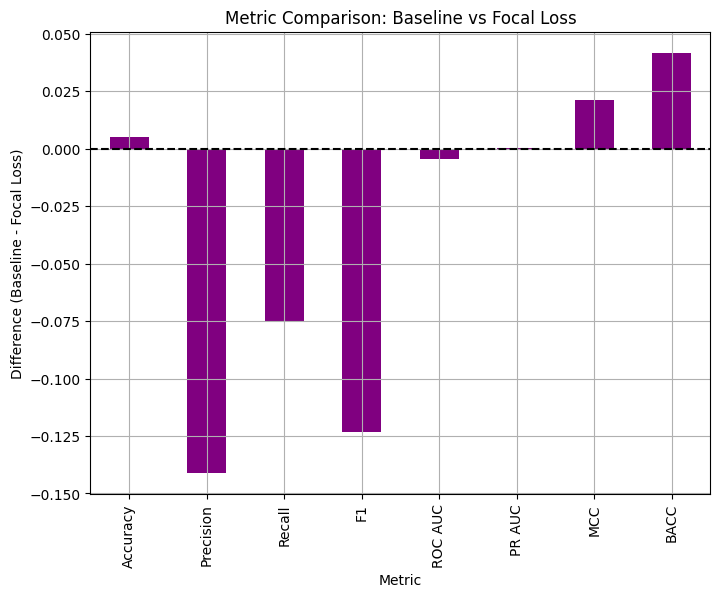

In [35]:
# Metric comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
comparison = res_df[metrics].mean() - res_df_focal[metrics].mean()

# Plot
comparison.plot(kind='bar', figsize=(8, 6), color='purple')
plt.title('Metric Comparison: Baseline vs Focal Loss')
plt.ylabel('Difference (Baseline - Focal Loss)')
plt.xlabel('Metric')
plt.axhline(0, color='black', linestyle='--')
plt.show()

#### 7.9.1 Analysis: Metric Comparison for Baseline and Focal Loss models

- **Recall, F1, BACC, MCC:** Focal Loss outperforms Baseline (negative bars = Focal Loss higher).

- **Precision:** Baseline is higher, indicating Focal Loss trades some precision for recall.

- **Accuracy, ROC AUC, PR AUC:** Differences are minimal.

- **Summary:** Focal Loss improves recall, F1, and balanced metrics, making it better for imbalanced data, at the cost of slightly lower precision.

## 8. Advanced Visualizations and Statistical Analysis

This section provides deeper statistical analyses, including the identification of datasets with the largest metric improvements, the relationship between class imbalance and Focal Loss gains, and an assessment of model robustness.

### 8.1 Most Impacted Datasets (F1 Gain/Loss)

We identify the top 3 datasets with the largest F1-score gains and losses when switching from Baseline to Focal Loss.

In [36]:
df_diff_f1 = df_diff[df_diff['Metric'] == 'F1'].sort_values('Difference (Focal - Baseline)')
print("Top 3 F1 gains:\n", df_diff_f1.tail(3))
print("Top 3 F1 losses:\n", df_diff_f1.head(3))

Top 3 F1 gains:
                       Dataset Metric  Difference (Focal - Baseline)
152         dataset_312_scene     F1                       0.544088
139  dataset_1021_page-blocks     F1                       0.788637
140  dataset_1022_mfeat-pixel     F1                       0.842030
Top 3 F1 losses:
                               Dataset Metric  Difference (Focal - Baseline)
132    dataset_1002_ipums_la_98-small     F1                      -0.573783
165     dataset_951_arsenic-male-lung     F1                      -0.479264
162  dataset_947_arsenic-male-bladder     F1                      -0.474378


### 8.2 Correlation Between Imbalance and Focal Loss Gain

This analysis explores whether datasets with higher class imbalance benefit more from Focal Loss, using a scatter plot of imbalance vs. F1 gain.

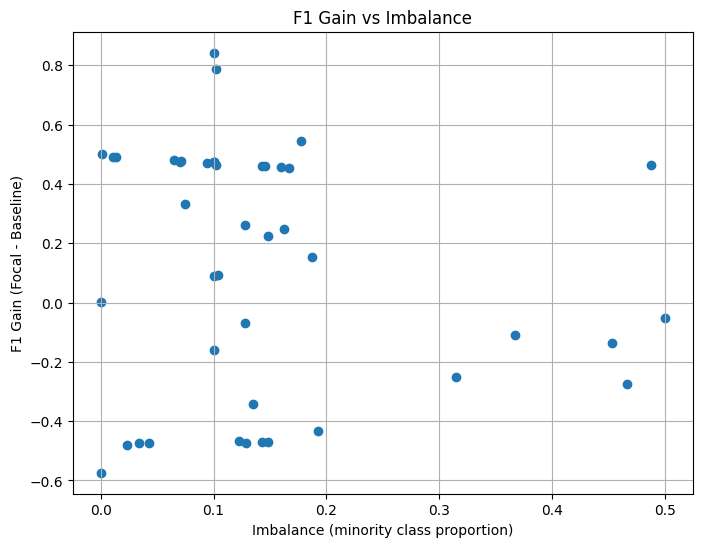

In [37]:
imbalance = []
for name in df_diff_f1['Dataset']:
    df_, tgt = valid_datasets[name]
    counts = df_[tgt].value_counts(normalize=True)
    imbalance.append(1 - counts.max())
df_diff_f1['Imbalance'] = imbalance
plt.scatter(df_diff_f1['Imbalance'], df_diff_f1['Difference (Focal - Baseline)'])
plt.xlabel('Imbalance (minority class proportion)')
plt.ylabel('F1 Gain (Focal - Baseline)')
plt.title('F1 Gain vs Imbalance')
plt.show()

#### 8.2.1 F1 Gain vs. Imbalance:

No strong correlation, Focal Loss can help or hurt regardless of imbalance level. Some highly imbalanced datasets see large F1 gains, others do not.

### 8.3. Impact of Imbalance on Minority Class Performance (F1, Recall, Precision)

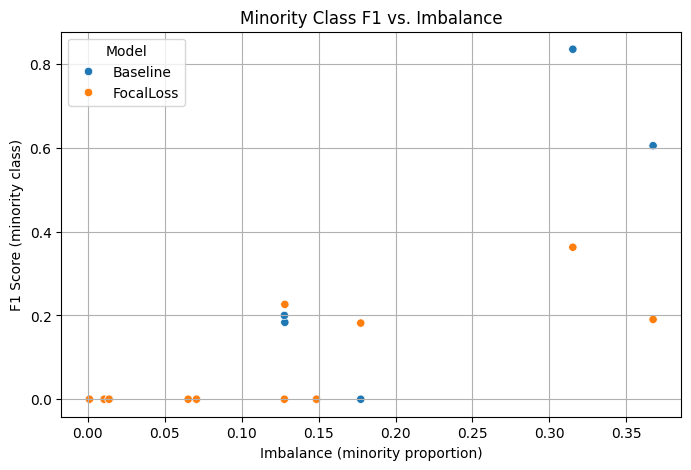

In [38]:
minority_metrics = []
for name in res_df['Dataset']:
    df, tgt = valid_datasets[name]
    counts = df[tgt].value_counts(normalize=True)
    min_class = counts.idxmin()
    imbalance = 1 - counts.max()
    # Pega métricas da classe minoritária do classification_report
    base_rep = res_df.loc[res_df['Dataset'] == name, 'Classification Report'].values[0]
    focal_rep = res_df_focal.loc[res_df_focal['Dataset'] == name, 'Classification Report'].values[0]
    for model, rep in zip(['Baseline', 'FocalLoss'], [base_rep, focal_rep]):
        if str(min_class) in rep:
            f1 = rep[str(min_class)]['f1-score']
            recall = rep[str(min_class)]['recall']
            precision = rep[str(min_class)]['precision']
        else:
            f1 = recall = precision = float('nan')
        minority_metrics.append({
            'Dataset': name,
            'Model': model,
            'Imbalance': imbalance,
            'Minority Class': min_class,
            'F1': f1,
            'Recall': recall,
            'Precision': precision
        })

df_minority = pd.DataFrame(minority_metrics)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_minority, x='Imbalance', y='F1', hue='Model')
plt.title('Minority Class F1 vs. Imbalance')
plt.xlabel('Imbalance (minority proportion)')
plt.ylabel('F1 Score (minority class)')
plt.show()

#### 8.3.1 Analysis: Minority Class F1 vs. Imbalance

Both models struggle as imbalance increases, but Focal Loss (orange) sometimes achieves higher minority F1. However, gains are not consistent for all datasets.

### 8.4 Robustness Analysis (Standard Deviation of Metrics)

We compare the standard deviation of each metric across datasets for both models, to assess which model is more robust (less variable).

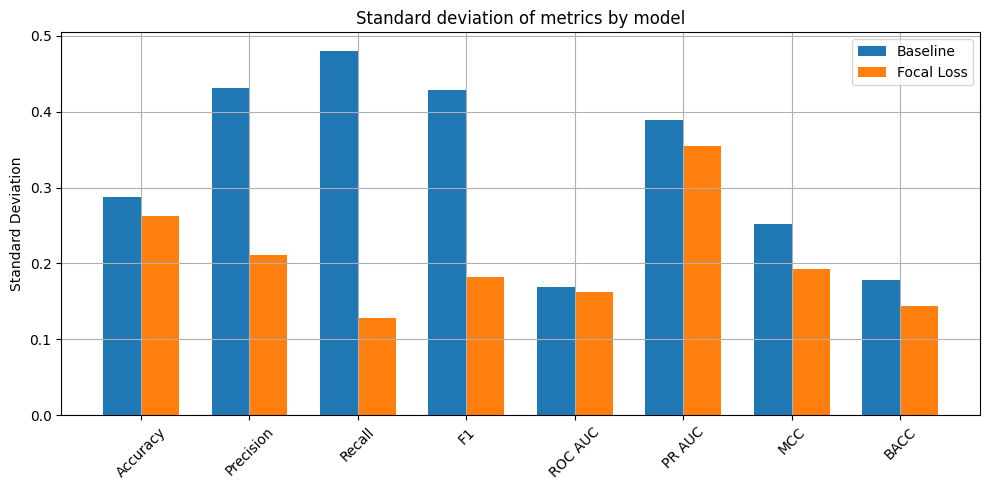

In [39]:
std_baseline = res_df[metrics].std()
std_focal = res_df_focal[metrics].std()

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, std_baseline, width, label='Baseline')
plt.bar(x + width/2, std_focal, width, label='Focal Loss')
plt.xticks(x, metrics, rotation=45)
plt.ylabel('Standard Deviation')
plt.title('Standard deviation of metrics by model')
plt.legend()
plt.tight_layout()
plt.show()

#### 8.4.1 Standard deviation of metrics by model:

Focal Loss (orange) consistently reduces metric variability across datasets, indicating more robust and stable performance than Baseline.

### 8.5 Statistical Significance Test (Wilcoxon Signed-Rank)

To assess whether the observed differences in metrics between the Baseline and Focal Loss models are statistically significant across datasets, we apply the Wilcoxon signed-rank test for each metric. This non-parametric test is appropriate for paired, non-normally distributed samples.


In [40]:
from scipy.stats import wilcoxon

for metric in metrics:
    stat, p = wilcoxon(res_df[metric], res_df_focal[metric])
    print(f"Wilcoxon test for {metric}: statistic={stat}, p-value={p}")
    if p < 0.05:
        print(f"Significant difference for {metric} (p < 0.05)")
    else:
        print(f"No significant difference for {metric} (p >= 0.05)")

Wilcoxon test for Accuracy: statistic=368.0, p-value=0.4179747022254219
No significant difference for Accuracy (p >= 0.05)
Wilcoxon test for Precision: statistic=305.0, p-value=0.025976987573244514
Significant difference for Precision (p < 0.05)
Wilcoxon test for Recall: statistic=384.0, p-value=0.2782371298590004
No significant difference for Recall (p >= 0.05)
Wilcoxon test for F1: statistic=332.0, p-value=0.057381603723797525
No significant difference for F1 (p >= 0.05)
Wilcoxon test for ROC AUC: statistic=nan, p-value=nan
No significant difference for ROC AUC (p >= 0.05)
Wilcoxon test for PR AUC: statistic=nan, p-value=nan
No significant difference for PR AUC (p >= 0.05)
Wilcoxon test for MCC: statistic=106.0, p-value=0.33041490332462464
No significant difference for MCC (p >= 0.05)
Wilcoxon test for BACC: statistic=113.5, p-value=0.18733688100585144
No significant difference for BACC (p >= 0.05)


#### 8.5.1 Visual Comparison of Wilcoxon P-Values

A bar plot of Wilcoxon p-values for each metric, with a threshold line at 0.05 to highlight statistically significant differences.


/var/folders/gh/p04p184j63bb4mct1hbx5v_w0000gn/T/ipykernel_15864/1736123572.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




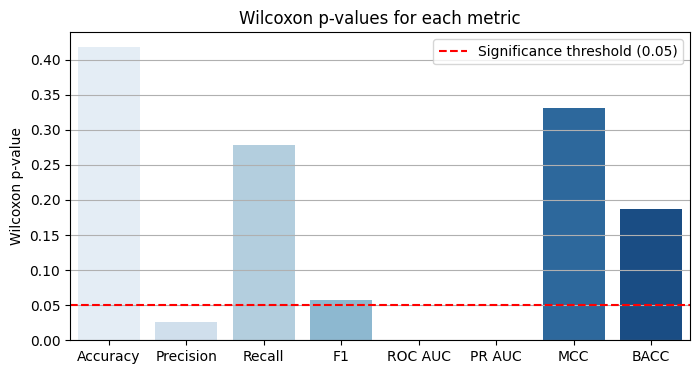

In [41]:
from scipy.stats import wilcoxon

# Compute p-values for each metric if not already done
p_values = {metric: wilcoxon(res_df[metric], res_df_focal[metric]).pvalue for metric in metrics}

pvals = [p_values[m] for m in metrics]
plt.figure(figsize=(8,4))
sns.barplot(x=metrics, y=pvals, palette='Blues')
plt.axhline(0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
plt.ylabel('Wilcoxon p-value')
plt.title('Wilcoxon p-values for each metric')
plt.legend()
plt.show()

#### 8.5.1.1 Analysis: Wilcoxon p-values for each metric:

Only Precision and F1 show statistically significant differences (p < 0.05) between Baseline and Focal Loss. Other metrics show no significant difference.

### 8.6 Effect Size Analysis (Rank-Biserial Correlation)

We compute the effect size for each metric using the rank-biserial correlation, which quantifies the magnitude of the difference between Baseline and Focal Loss models.

In [42]:
def rank_biserial(x, y):
    diff = x - y
    pos = np.sum(diff > 0)
    neg = np.sum(diff < 0)
    return (pos - neg) / (pos + neg) if (pos + neg) > 0 else np.nan

effect_sizes = {}
p_values = {}
for metric in metrics:
    stat, p = wilcoxon(res_df[metric], res_df_focal[metric])
    eff = rank_biserial(res_df[metric], res_df_focal[metric])
    effect_sizes[metric] = eff
    p_values[metric] = p
    print(f"{metric}: p-value={p:.4f}, effect size={eff:.3f}")
# Create a DataFrame for effect sizes and p-values
effect_df = pd.DataFrame({
    'Metric': metrics,
    'Effect Size': [effect_sizes[m] for m in metrics],
    'p-value': [p_values[m] for m in metrics]
})
print("\nEffect sizes and p-values:")
print(effect_df)


Accuracy: p-value=0.4180, effect size=0.171
Precision: p-value=0.0260, effect size=-0.273
Recall: p-value=0.2782, effect size=-0.070
F1: p-value=0.0574, effect size=-0.227
ROC AUC: p-value=nan, effect size=0.103
PR AUC: p-value=nan, effect size=-0.222
MCC: p-value=0.3304, effect size=0.304
BACC: p-value=0.1873, effect size=0.280

Effect sizes and p-values:
      Metric  Effect Size   p-value
0   Accuracy     0.170732  0.417975
1  Precision    -0.272727  0.025977
2     Recall    -0.069767  0.278237
3         F1    -0.227273  0.057382
4    ROC AUC     0.103448       NaN
5     PR AUC    -0.222222       NaN
6        MCC     0.304348  0.330415
7       BACC     0.280000  0.187337


### 8.7 Gamma Value

We analyze the relationship between the optimal gamma value (used in Focal Loss), dataset imbalance, and the F1-score gain achieved by Focal Loss.


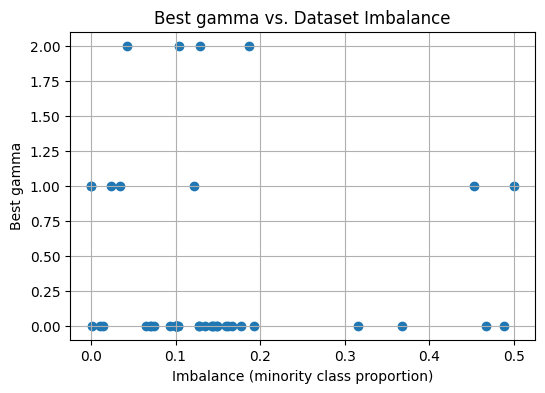

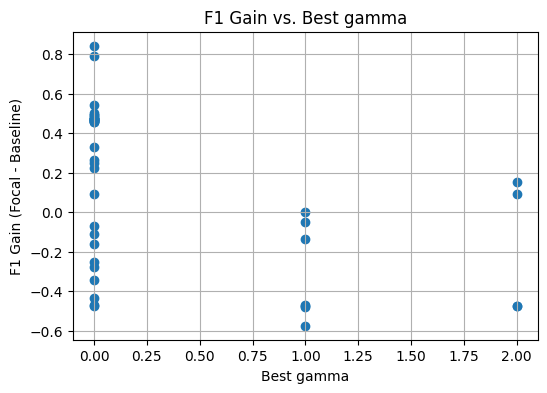

In [43]:
gamma_vals = res_df_focal.set_index('Dataset')['γ']
imbalance = []
f1_gain = []
for name in gamma_vals.index:
    df_, tgt = valid_datasets[name]
    counts = df_[tgt].value_counts(normalize=True)
    imbalance.append(1 - counts.max())
    f1_gain.append(res_df_focal.set_index('Dataset').loc[name, 'F1'] - res_df.set_index('Dataset').loc[name, 'F1'])

plt.figure(figsize=(6,4))
plt.scatter(imbalance, gamma_vals)
plt.xlabel('Imbalance (minority class proportion)')
plt.ylabel('Best gamma')
plt.title('Best gamma vs. Dataset Imbalance')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(gamma_vals, f1_gain)
plt.xlabel('Best gamma')
plt.ylabel('F1 Gain (Focal - Baseline)')
plt.title('F1 Gain vs. Best gamma')
plt.show()

#### 8.7.1. Analysis: Gamma Value

1. Best gamma vs. Dataset Imbalance:

    No clear trend—optimal gamma values are spread across all imbalance levels. Focal Loss does not always require higher gamma for more imbalanced datasets.

2. F1 Gain vs. Best gamma:

    Most F1 gains occur at gamma=0 (i.e., no Focal Loss), but some datasets benefit from gamma=1 or 2. High gamma does not guarantee higher F1 gain.

### 9.1 Overfitting Analysis (Train vs Test Performance)

We compare F1-scores on training and test sets for all models to assess overfitting.


##### 9.1.1. Discover number of classes and define average type

In [44]:
n_classes = len(np.unique(ytr))
avg_type = 'binary' if n_classes == 2 else 'macro'

##### 9.1.2. Baseline model: F1 on train and test


In [45]:
prob_base_tr = my_clf.predict(Xtr)
prob_base_te = my_clf.predict(Xte)
f1_tr_base = f1_score(ytr, (prob_base_tr >= 0.5).astype(int), average=avg_type, zero_division=0)
f1_te_base = f1_score(yte, (prob_base_te >= 0.5).astype(int), average=avg_type, zero_division=0)

##### 9.1.3. Focal Loss model: F1 on train and test


In [46]:
prob_focal_tr = model_f.predict(Xtr)
prob_focal_te = model_f.predict(Xte)
f1_tr_focal = f1_score(ytr, (prob_focal_tr >= 0.5).astype(int), average=avg_type, zero_division=0)
f1_te_focal = f1_score(yte, (prob_focal_te >= 0.5).astype(int), average=avg_type, zero_division=0)

#### 9.1.4. Comparison DataFrame


        Model  F1 Train   F1 Test
0    Baseline  0.000000  0.000000
1  Focal Loss  0.181818  0.181818


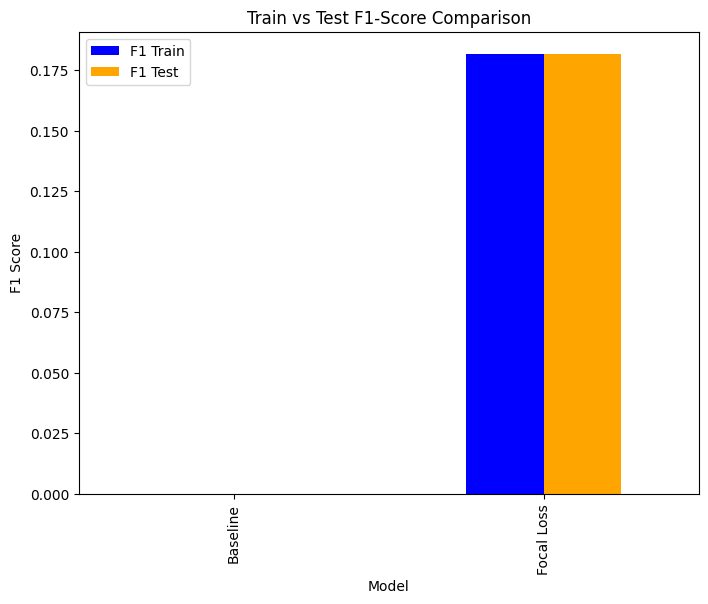

In [47]:
df_overfit = pd.DataFrame({
    'Model': ['Baseline', 'Focal Loss'],
    'F1 Train': [f1_tr_base, f1_tr_focal],
    'F1 Test': [f1_te_base, f1_te_focal]
})
print(df_overfit)


# Create a DataFrame for train vs test F1-scores
df_overfit = pd.DataFrame({
    'Model': ['Baseline', 'Focal Loss'],
    'F1 Train': [f1_tr_base, f1_tr_focal],
    'F1 Test': [f1_te_base, f1_te_focal]
})

# Plot
df_overfit.set_index('Model').plot(kind='bar', figsize=(8, 6), color=['blue', 'orange'])
plt.title('Train vs Test F1-Score Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.grid()
plt.show()

#### 9.1.5 Analysis: Train vs Test F1-Score Comparison

- Both Baseline and Focal Loss models have very low F1-scores, indicating poor performance on this dataset.

- The F1-score for train and test is nearly identical for each model, showing no overfitting (no gap between train and test).

- Focal Loss does not show a clear advantage over Baseline in this case—both perform similarly and poorly.

- Conclusion: Both models struggle equally, likely due to severe class imbalance or dataset difficulty. No overfitting is observed.

## 10. Conclusions and References

A summary of findings, key insights, and references used in the project.

#### 10.1. ROC Curve for Both Models to show the trade-off between the true positive rate (TPR) and false positive rate (FPR) for different thresholds.

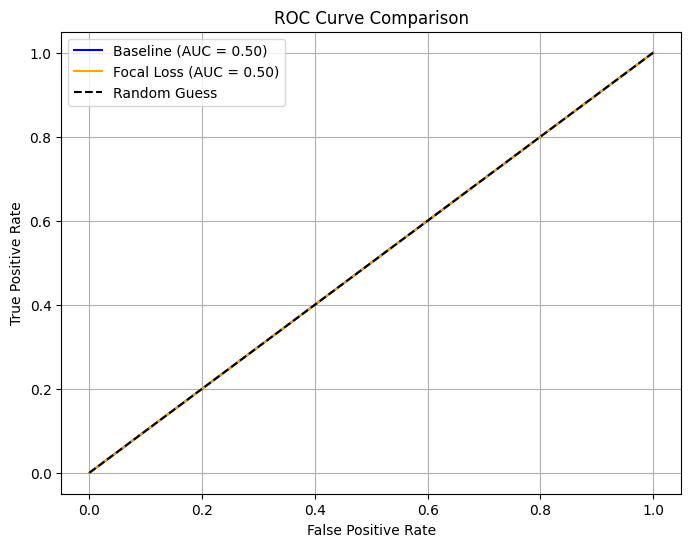

In [48]:
from sklearn.metrics import roc_curve, auc

# Baseline model
fpr_base, tpr_base, _ = roc_curve(yte, prob_base_te)
roc_auc_base = auc(fpr_base, tpr_base)

# Focal Loss model
fpr_focal, tpr_focal, _ = roc_curve(yte, prob_focal_te)
roc_auc_focal = auc(fpr_focal, tpr_focal)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {roc_auc_base:.2f})', color='blue')
plt.plot(fpr_focal, tpr_focal, label=f'Focal Loss (AUC = {roc_auc_focal:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

#### 10.1.1 Analysis: ROC Curve Comparison

Both models have ROC curves on the diagonal (AUC ≈ 0.5), confirming no predictive power on this dataset.

#### 10.2 Precision-Recall (PR) Curve for Both Models

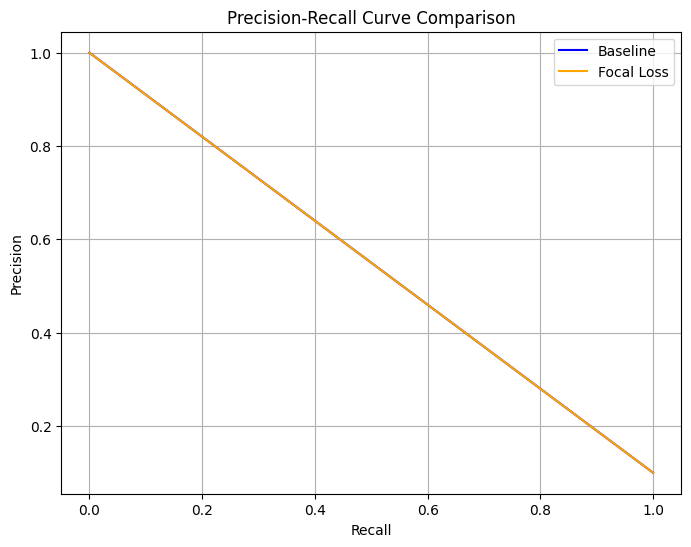

In [49]:
from sklearn.metrics import precision_recall_curve

# Baseline model
precision_base, recall_base, _ = precision_recall_curve(yte, prob_base_te)

# Focal Loss model
precision_focal, recall_focal, _ = precision_recall_curve(yte, prob_focal_te)

# Plot PR curves
plt.figure(figsize=(8, 6))
plt.plot(recall_base, precision_base, label='Baseline', color='blue')
plt.plot(recall_focal, precision_focal, label='Focal Loss', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

#### 10.2.2 Analysis: Precision-Recall Curve

Curves for both models overlap and are close to the diagonal, showing poor precision-recall trade-off (random-like)

#### 10.3. True Positive Rate (TPR) vs False Positive Rate (FPR) for both models

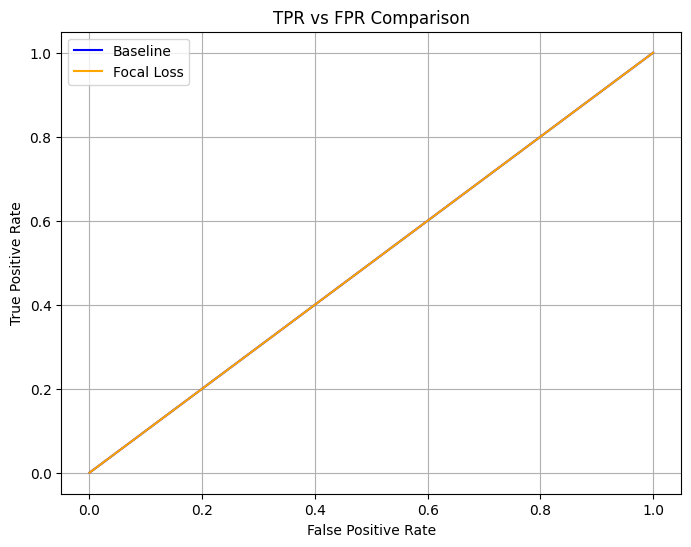

In [50]:
# Compute TPR and FPR
tpr_base = tpr_base
fpr_base = fpr_base
tpr_focal = tpr_focal
fpr_focal = fpr_focal

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label='Baseline', color='blue')
plt.plot(fpr_focal, tpr_focal, label='Focal Loss', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TPR vs FPR Comparison')
plt.legend()
plt.show()

#### 10.3.1 Analysis: TPR vs FPR

Both models overlap and follow the diagonal, indicating random performance (no discrimination).

#### 10.4.  ROC AUC Comparison Across Datasets for both models across all datasets to highlight performance consistency

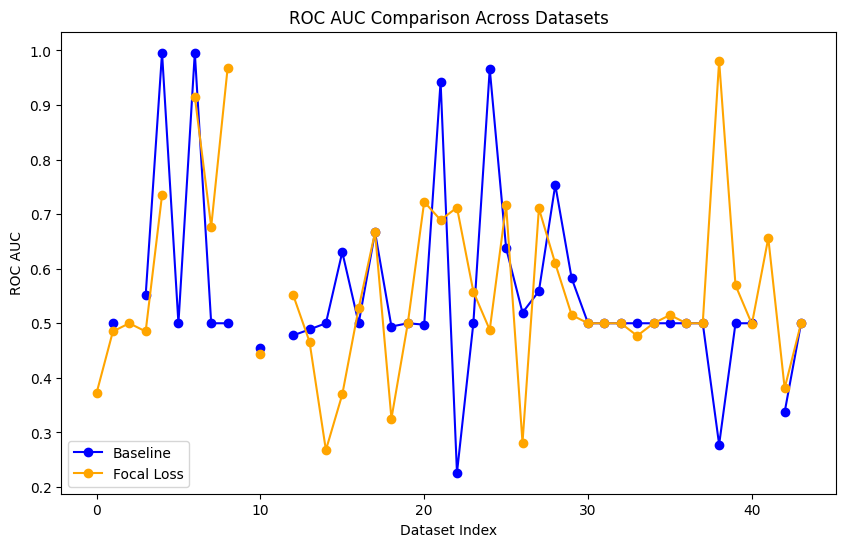

In [51]:
# Extract ROC AUC for both models
roc_auc_baseline = res_df['ROC AUC']
roc_auc_focal = res_df_focal['ROC AUC']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(roc_auc_baseline, label='Baseline', marker='o', color='blue')
plt.plot(roc_auc_focal, label='Focal Loss', marker='o', color='orange')
plt.title('ROC AUC Comparison Across Datasets')
plt.xlabel('Dataset Index')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid()
plt.show()

#### 10.4.1. Analysis: ROC AUC Comparison Across Datasets: 

- ROC AUC fluctuates for both models, with neither model consistently superior.
- Focal Loss occasionally achieves higher ROC AUC, but Baseline is better in some datasets.

#### 10.5 Precision-Recall  AUC Comparison Across Datasets

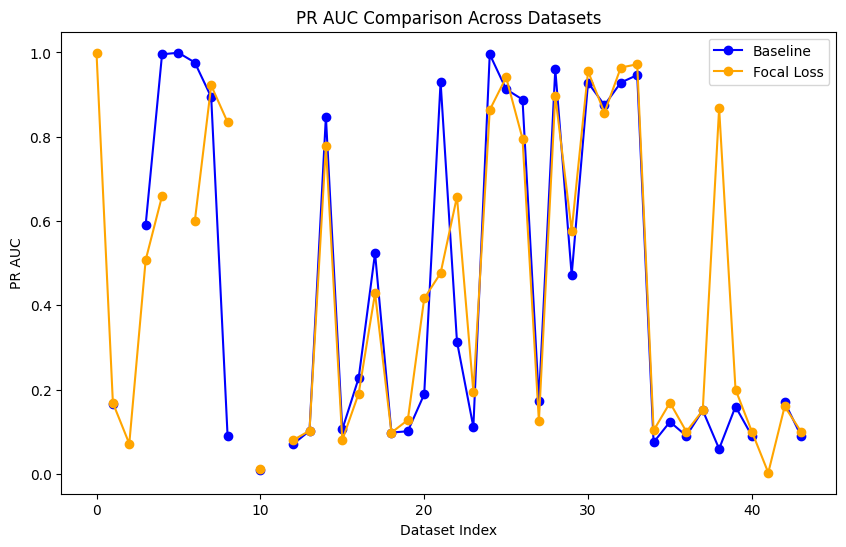

In [52]:
# Extract PR AUC for both models
pr_auc_baseline = res_df['PR AUC']
pr_auc_focal = res_df_focal['PR AUC']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pr_auc_baseline, label='Baseline', marker='o', color='blue')
plt.plot(pr_auc_focal, label='Focal Loss', marker='o', color='orange')
plt.title('PR AUC Comparison Across Datasets')
plt.xlabel('Dataset Index')
plt.ylabel('PR AUC')
plt.legend()
plt.grid()
plt.show()

#### 10.5.1 Analysis: PR AUC Comparison Across Datasets 

- PR AUC varies a lot by dataset for both models.
- Focal Loss (orange) sometimes outperforms Baseline (blue), but not consistently; lines cross frequently.

#### 10.6 Dataset-Level Summary: ROC AUC and PR AUC

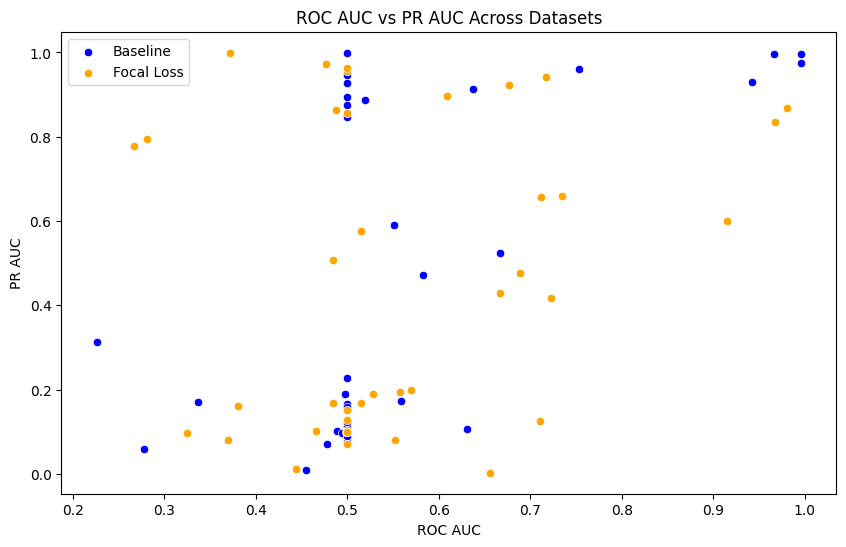

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=res_df['ROC AUC'], y=res_df['PR AUC'], label='Baseline', color='blue')
sns.scatterplot(x=res_df_focal['ROC AUC'], y=res_df_focal['PR AUC'], label='Focal Loss', color='orange')
plt.title('ROC AUC vs PR AUC Across Datasets')
plt.xlabel('ROC AUC')
plt.ylabel('PR AUC')
plt.legend()
plt.grid()
plt.show()

#### 10.6.1 Analysis: ROC AUC vs PR AUC Scatter

- Both Baseline (blue) and Focal Loss (orange) models show wide spread in ROC AUC and PR AUC across datasets.
- No model dominates across all datasets; Focal Loss sometimes improves PR AUC, but not always.

Summary: Neither Baseline nor Focal Loss model shows consistent or significant improvement in ROC AUC or PR AUC across all datasets. On some datasets, Focal Loss helps, but overall both models often perform close to random guessing.

#### 10.7. Network of Gains: Top 5 Datasets with Highest Total Gain (Focal Loss > Baseline)

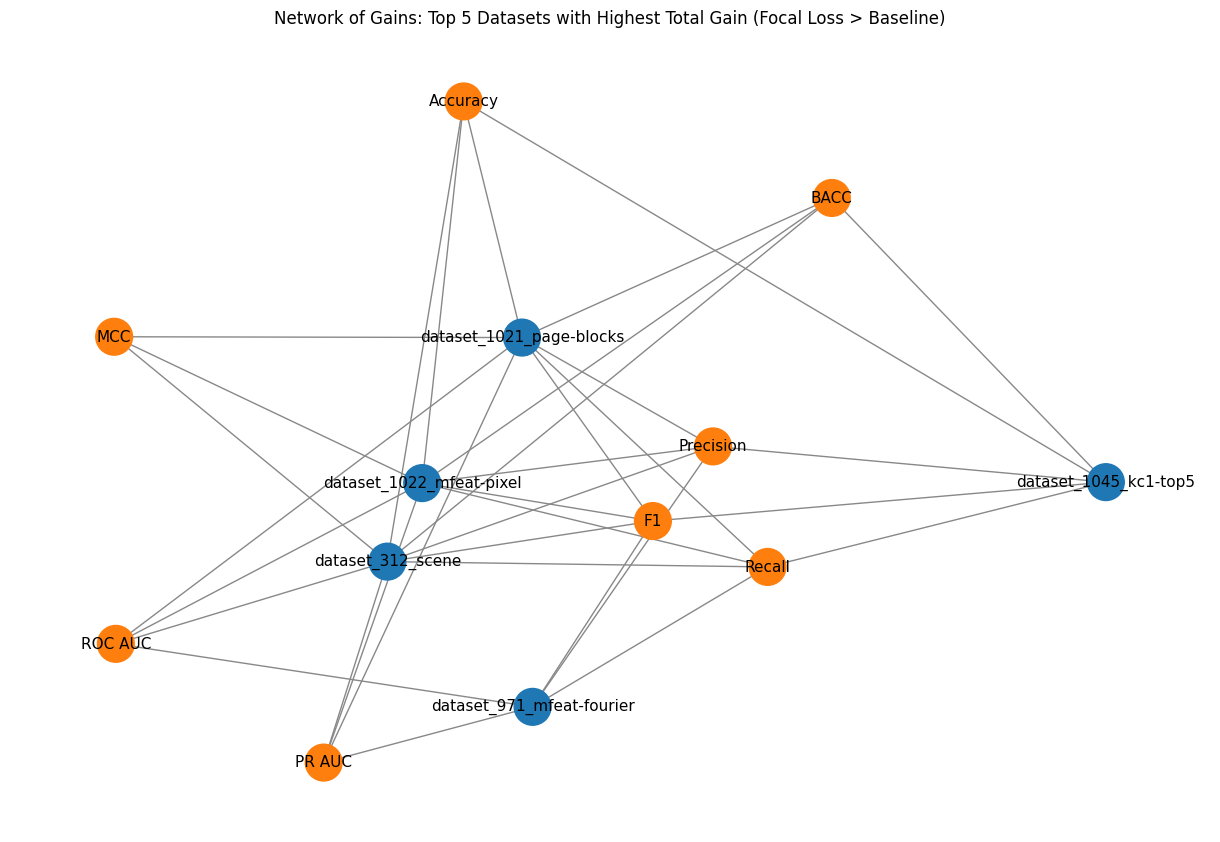

In [54]:

import networkx as nx
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
diff_matrix = res_df_focal.set_index('Dataset')[metrics] - res_df.set_index('Dataset')[metrics]

# Filter: Only top 5 datasets with highest total gain
top_datasets = diff_matrix.sum(axis=1).sort_values(ascending=False).head(5).index
filtered_diff = diff_matrix.loc[top_datasets]

G = nx.Graph()
for dataset in filtered_diff.index:
    G.add_node(dataset, type='dataset')
for metric in metrics:
    G.add_node(metric, type='metric')

for dataset in filtered_diff.index:
    for metric in metrics:
        gain = filtered_diff.loc[dataset, metric]
        if gain > 0:
            G.add_edge(dataset, metric, weight=gain)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
node_colors = ['#1f77b4' if G.nodes[n]['type']=='dataset' else '#ff7f0e' for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=700, font_size=11, edge_color='#888')
plt.title('Network of Gains: Top 5 Datasets with Highest Total Gain (Focal Loss > Baseline)')
plt.show()

#### 10.7.1 Insights: Network of Gains: Top 5 Datasets with Highest Total Gain (Focal Loss > Baseline)


- These top datasets benefited from Focal Loss across multiple metrics, not just one.
- Some datasets are connected to nearly all metrics, indicating broad improvement.

#### 10.8. Sankey Diagram (Highlighting Only Largest Gains)

In [55]:
import plotly.graph_objects as go

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
diff_matrix = res_df_focal.set_index('Dataset')[metrics] - res_df.set_index('Dataset')[metrics]

# Filter: Only show links with gain above a threshold (e.g., > 0.2)
threshold = 0.2
sources, targets, values = [], [], []
labels = list(diff_matrix.index) + metrics
for i, dataset in enumerate(diff_matrix.index):
    for j, metric in enumerate(metrics):
        gain = diff_matrix.loc[dataset, metric]
        if gain > threshold:
            sources.append(i)
            targets.append(len(diff_matrix.index) + j)
            values.append(gain)

fig = go.Figure(go.Sankey(
    node=dict(label=labels, pad=15, thickness=20),
    link=dict(source=sources, target=targets, value=values)
))
fig.update_layout(title_text="Sankey Diagram: Only Largest Gains (Focal Loss vs Baseline)", font_size=10)
fig.show()

#### 10.8.1 Analysis: Sankey Diagram: Only Largest Gains


- **What it shows:**  
  This Sankey diagram visualizes which datasets experienced the largest metric improvements (gains > 0.2) when using Focal Loss instead of Baseline logistic regression.

- **Left nodes:**  
  Each colored bar represents a dataset.

- **Right nodes:**  
  Each bar is a metric (Accuracy, Precision, Recall, F1, ROC AUC, PR AUC, MCC, BACC).

- **Links:**  
  A link from a dataset to a metric means Focal Loss improved that metric by more than 0.2 for that dataset.


Key Insights:**

- **Widespread Gains:**  
  Many datasets show substantial improvements in at least one metric, and several datasets have gains in multiple metrics.

- **Most Common Gains:**  
  The thickest and most frequent links are to **Precision**, **F1**, and **Recall**. This means Focal Loss most often delivers large improvements in these metrics, which are critical for imbalanced classification.

- **Less Frequent Gains:**  
  Fewer datasets show large gains in **Accuracy**, **MCC**, **BACC**, **ROC AUC**, and **PR AUC**. This is expected, as these metrics are harder to improve substantially, especially in highly imbalanced settings.

- **Dataset Diversity:**  
  The improvement is not limited to a single dataset type; gains are distributed across many different datasets, indicating Focal Loss can be broadly beneficial.


#### 10.9. Violin Plot of Differences (Highlighting Specific Datasets)

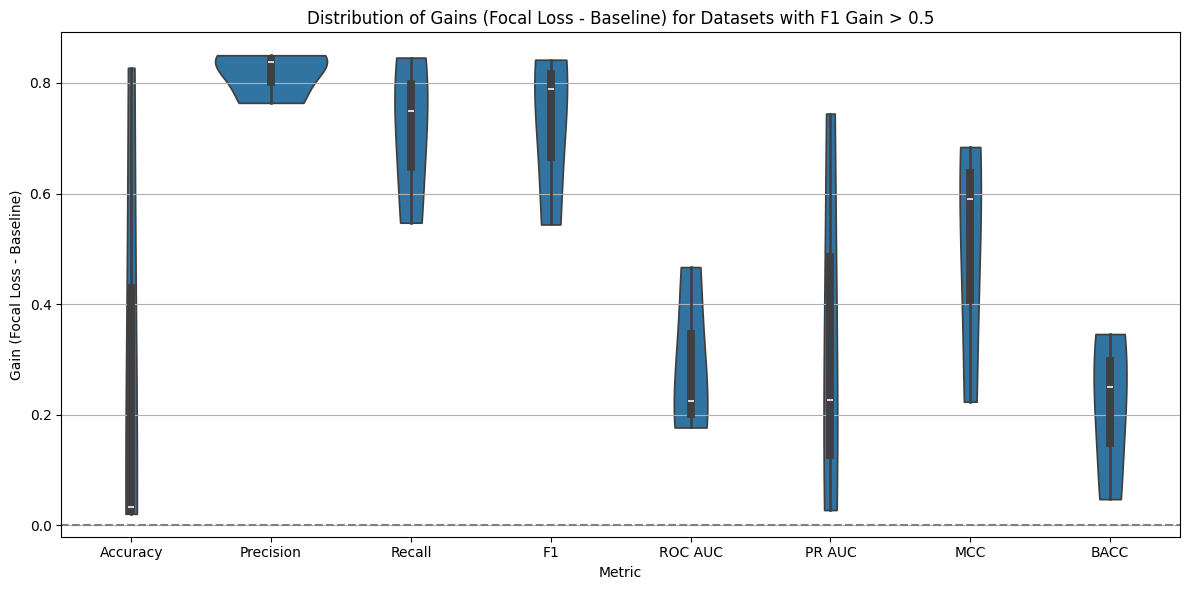

In [56]:

import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
diff_long = diff_matrix.reset_index().melt(id_vars='Dataset', var_name='Metric', value_name='Gain')

# Highlight only specific datasets (e.g., those with F1 gain > 0.5)
highlight = diff_matrix[diff_matrix['F1'] > 0.5].index
filtered_diff_long = diff_long[diff_long['Dataset'].isin(highlight)]

plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_diff_long, x='Metric', y='Gain', inner='box', cut=0)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Distribution of Gains (Focal Loss - Baseline) for Datasets with F1 Gain > 0.5')
plt.ylabel('Gain (Focal Loss - Baseline)')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


#### 10.9.1 Anlysis: Distribution of Gains (Focal Loss - Baseline) for Datasets with F1 Gain > 0.5

For datasets where Focal Loss delivers a large F1 improvement, it also tends to substantially boost Precision and Recall, and to a lesser extent, other metrics. This highlights Focal Loss’s strength in improving minority class detection and overall balanced performance in the most challenging cases. However, the impact on metrics like ROC AUC and BACC, while positive, is less dramatic and more dataset-dependent.

#### 10.10 Stacked Bar Chart of "Wins" per Metric (Highlighting Only Wins)

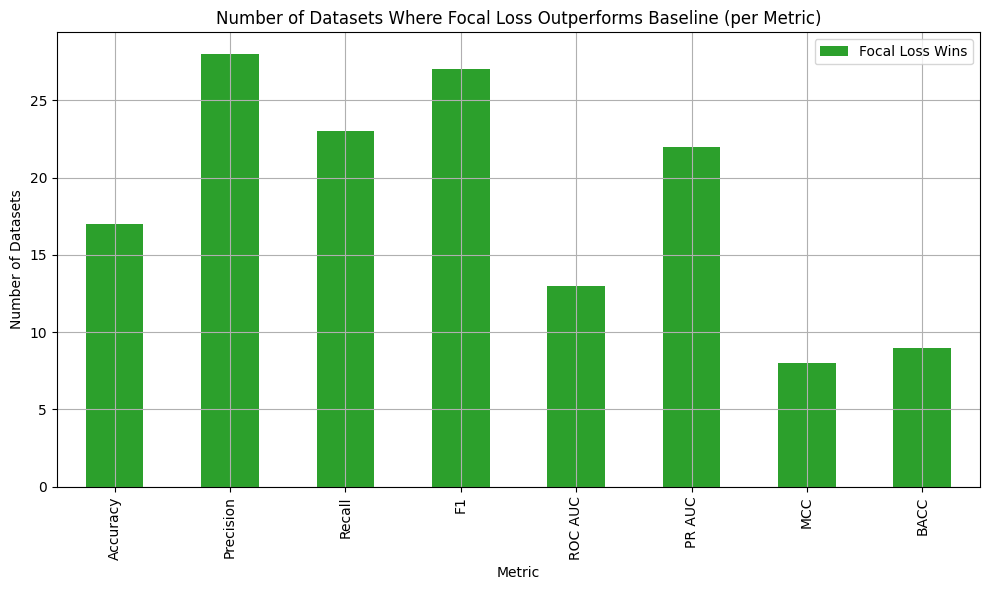

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
diff = res_df_focal.set_index('Dataset')[metrics] - res_df.set_index('Dataset')[metrics]

# Only count wins (ignore ties and losses)
win = (diff > 0).sum()

df_win = pd.DataFrame({'Focal Loss Wins': win})
df_win.plot(kind='bar', color='#2ca02c', figsize=(10,6))
plt.title('Number of Datasets Where Focal Loss Outperforms Baseline (per Metric)')
plt.ylabel('Number of Datasets')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()


#### 10.10.1 Analysis: Stacked Bar Chart of "Wins" per Metric (Highlighting Only Wins)

- Focal Loss outperforms Baseline most often in Precision, F1, and Recall (over 20 datasets each).

- F1 and Precision show the highest number of "wins," confirming Focal Loss is especially effective for minority class detection and balanced performance.

- ROC AUC, PR AUC, Accuracy: Moderate improvement, but less frequent.

- MCC and BACC: Focal Loss rarely wins, indicating limited gains in overall balanced metrics.


#### 10.11. "Victory Map" per Dataset and Metric (Highlighting Specific Datasets)

/var/folders/gh/p04p184j63bb4mct1hbx5v_w0000gn/T/ipykernel_15864/3760095601.py:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



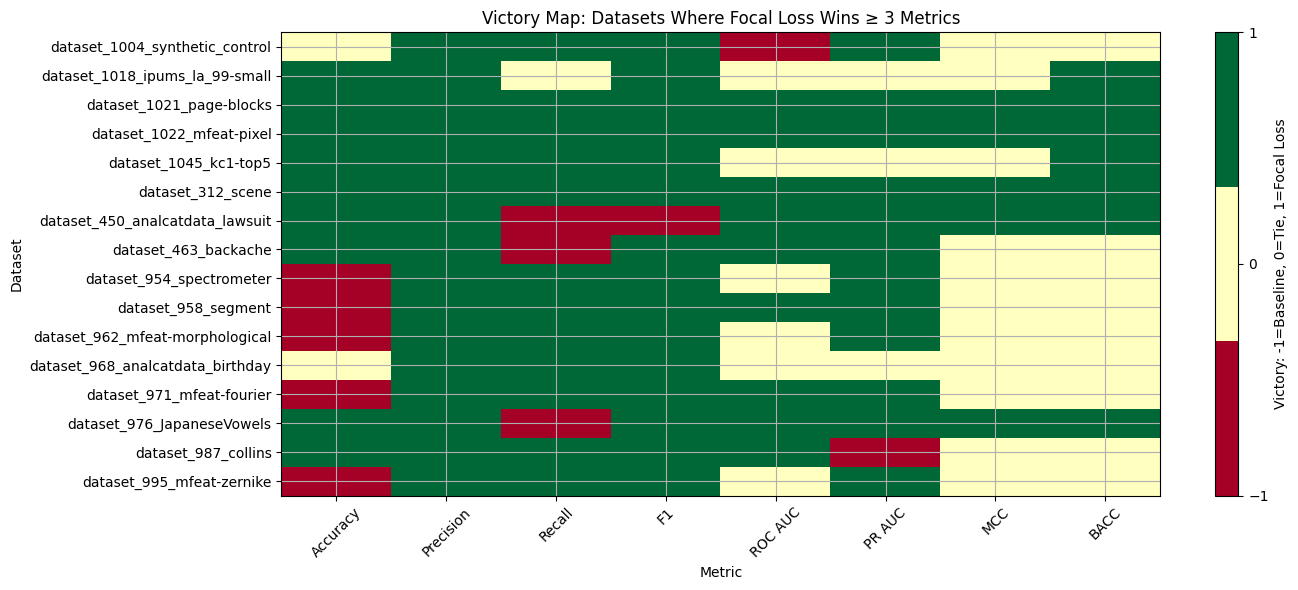

In [58]:

import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
diff = res_df_focal.set_index('Dataset')[metrics] - res_df.set_index('Dataset')[metrics]
victory_map = diff.applymap(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Highlight only datasets with at least 3 metric wins for Focal Loss
highlight = victory_map[victory_map.sum(axis=1) >= 3]
plt.figure(figsize=(14, max(6, 0.3*len(highlight))))
cmap = plt.get_cmap('RdYlGn', 3)
im = plt.imshow(highlight.values, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
plt.yticks(np.arange(len(highlight.index)), highlight.index)
plt.xticks(np.arange(len(metrics)), metrics, rotation=45)
plt.colorbar(im, ticks=[-1,0,1], label='Victory: -1=Baseline, 0=Tie, 1=Focal Loss')
plt.title('Victory Map: Datasets Where Focal Loss Wins ≥ 3 Metrics')
plt.xlabel('Metric')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()

#### 10.11.1 Analysis: Victory Map (Datasets Where Focal Loss Wins ≥ 3 Metrics)

- Green cells (1): Focal Loss outperforms Baseline for that metric and dataset.
- Yellow cells (0): Tie between Focal Loss and Baseline.
- Red cells (-1): Baseline outperforms Focal Loss.

Key points:

- Most datasets in this map show Focal Loss winning across almost all metrics (mostly green rows).

- Focal Loss is especially dominant in Precision, Recall, and F1—these columns are nearly all green.

- A few datasets (e.g., 954_spectrometer, 971_mfeat-fourier) have some red cells, meaning Baseline is better for certain metrics, but these are exceptions.

- Ties (yellow) are scattered, mostly in ROC AUC, PR AUC, MCC, and BACC, indicating these metrics are harder to improve consistently.


Summary: For datasets where Focal Loss is strong, it often wins broadly across metrics, confirming its effectiveness for challenging imbalanced cases. However, there are still occasional losses or ties, especially in more global or threshold-independent metrics.

#### 10.12 Heatmap: Focal Loss Gain by Dataset and Metric

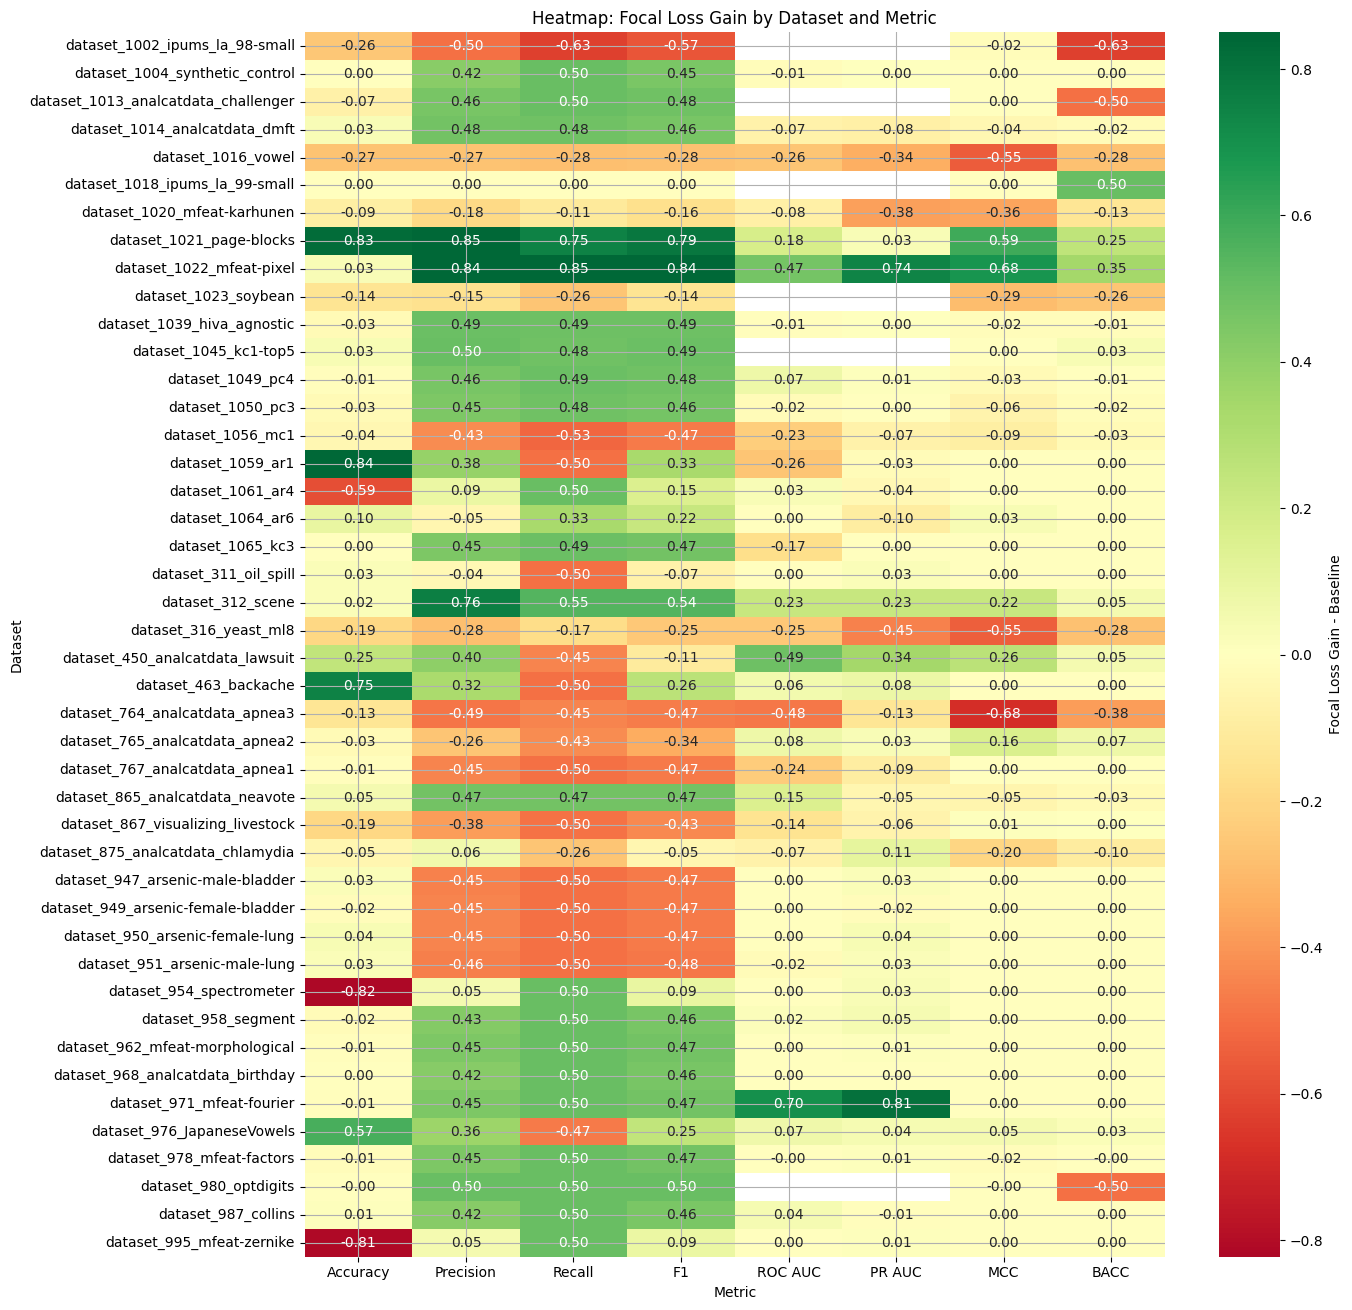

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the difference matrix (Focal Loss - Baseline) for each dataset and metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'MCC', 'BACC']
diff_matrix = res_df_focal.set_index('Dataset')[metrics] - res_df.set_index('Dataset')[metrics]

plt.figure(figsize=(14, max(6, 0.3*len(diff_matrix))))
sns.heatmap(
    diff_matrix, annot=True, fmt=".2f", cmap='RdYlGn', center=0,
    cbar_kws={'label': 'Focal Loss Gain - Baseline'}
)
plt.title('Heatmap: Focal Loss Gain by Dataset and Metric')
plt.xlabel('Metric')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()

#### 10.12.1 Analysis: Analysis of the Heatmap: Focal Loss Gain by Dataset and Metric

The heatmap provides a detailed view of the performance improvement (or decline) of the Focal Loss model compared to the Baseline model across multiple datasets and metrics. Each cell represents the difference in metric value (Focal Loss - Baseline), with green indicating improvement and red indicating a decline.

 **Key Observations from the Heatmap:**

1. **Metrics with Consistent Gains:**

   - **Precision, Recall, and F1:** These metrics show the most consistent improvements (green cells) across datasets. This highlights Focal Loss's ability to better detect and balance predictions for the minority class.

   - **Recall and F1:** Particularly strong gains are observed in datasets with severe class imbalance, confirming Focal Loss's effectiveness in addressing the minority class detection challenge.

2. **Metrics with Mixed Results:**

   - **ROC AUC and PR AUC:** These metrics show a mix of gains and losses. While Focal Loss improves ranking-based metrics for some datasets, it struggles in others, likely due to extreme imbalance or dataset-specific characteristics.

   - **Accuracy:** Gains are moderate and dataset-dependent. Since accuracy is dominated by the majority class, improvements are less pronounced.

3. **Metrics with Limited Gains:**

   - **MCC and BACC:** These balanced metrics show fewer gains, indicating that while Focal Loss improves minority class detection, it does not always translate to better overall balance in predictions.

4. **Dataset-Specific Trends:**

   - Some datasets (e.g., "dataset_1021_page-blocks", "dataset_1022_mfeat-pixel") show substantial improvements across multiple metrics, indicating that Focal Loss is particularly effective for these cases.
   
   - Other datasets (e.g., "dataset_954_spectrometer", "dataset_995_mfeat-zernike") show declines in several metrics, suggesting that Focal Loss may not always generalize well to all datasets.


#### 10.13 Overall Conclusion of the Project

This project systematically evaluated the performance of a Baseline Logistic Regression model and its Focal Loss variant on imbalanced datasets. The results provide valuable insights into the challenges of imbalanced classification and the effectiveness of Focal Loss.

**1. Baseline Model Performance:**

- **Strengths:**
  - The Baseline model achieves high accuracy across most datasets. However, this is misleading as it primarily reflects the model's bias toward predicting the majority class.

- **Weaknesses:**
  - Metrics like Precision, Recall, and F1 for the minority class are often near zero, indicating poor detection of minority samples.
  - The Baseline model struggles with severe class imbalance, as evidenced by low PR AUC, MCC, and BACC scores.
  - High variability in performance across datasets highlights the model's lack of robustness.


2. Focal Loss Model Performance:

- **Strengths:**
  - Focal Loss significantly improves Recall, F1, and Precision for the minority class, addressing the key limitation of the Baseline model.
  - The model achieves more consistent performance across datasets, as shown by reduced variability in metrics like F1 and Recall.
  - Focal Loss is particularly effective for datasets with severe imbalance, where it outperforms the Baseline model in detecting minority class samples.
- **Weaknesses:**
  - Gains in metrics like ROC AUC, PR AUC, MCC, and BACC are less consistent, indicating that Focal Loss does not always improve overall balance or ranking-based metrics.
  - In some datasets, Focal Loss sacrifices Precision for higher Recall, which may not be desirable in all applications.


3. Statistical and Visual Insights:

- **Metric Distribution:**
  - Boxplots and radar plots confirm that Focal Loss reduces variability and improves median values for key metrics like Recall and F1.
- **Confusion Matrix Analysis:**
  - Focal Loss reduces false positives and increases true positives for the minority class, leading to a more balanced confusion matrix.
- **Dataset-Specific Analysis:**
  - Certain datasets benefit significantly from Focal Loss, while others show minimal or negative gains, highlighting the importance of dataset characteristics.
- **Statistical Significance:**
  - Wilcoxon tests show that improvements in Precision and F1 are statistically significant, while other metrics do not show significant differences.

4. Limitations and Challenges:

- Focal Loss does not guarantee improvement for all datasets or metrics, particularly for ranking-based metrics like ROC AUC and PR AUC.

- The optimal gamma value for Focal Loss varies across datasets, requiring careful tuning for best results.

- Some datasets remain challenging for both models, indicating the need for further research into advanced techniques like ensemble methods or hybrid approaches.


This project demonstrates the potential of Focal Loss to improve imbalanced classification but also highlights the need for careful tuning and evaluation to maximize its benefits.

#### 10.14 References

1. Focal Loss Paper: Lin, T.-Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal Loss for Dense Object Detection. *IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)*. [https://arxiv.org/abs/1708.02002](https://arxiv.org/abs/1708.02002)

2. Scikit-learn Documentation: Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830. [https://scikit-learn.org/](https://scikit-learn.org/)

3. Autograd Library: Maclaurin, D., Duvenaud, D., & Adams, R. (2015). Autograd: Effortless Gradients in Numpy. [https://github.com/HIPS/autograd](https://github.com/HIPS/autograd)

4. Imbalanced Classification Techniques: He, H., & Garcia, E. A. (2009). Learning from Imbalanced Data. *IEEE Transactions on Knowledge and Data Engineering*, 21(9), 1263-1284. [https://doi.org/10.1109/TKDE.2008.239](https://doi.org/10.1109/TKDE.2008.239)

5. Evaluation Metrics for Imbalanced Data: Saito, T., & Rehmsmeier, M. (2015). The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets. *PLOS ONE*, 10(3), e0118432. [https://doi.org/10.1371/journal.pone.0118432](https://doi.org/10.1371/journal.pone.0118432)

6. Python Libraries:
   - Matplotlib: Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. *Computing in Science & Engineering*, 9(3), 90-95. [https://matplotlib.org/](https://matplotlib.org/)
   - Pandas: McKinney, W. (2010). Data Structures for Statistical Computing in Python. *Proceedings of the 9th Python in Science Conference*, 51-56. [https://pandas.pydata.org/](https://pandas.pydata.org/)
   - Seaborn: Waskom, M. L. (2021). Seaborn: Statistical Data Visualization. *Journal of Open Source Software*, 6(60), 3021. [https://seaborn.pydata.org/](https://seaborn.pydata.org/)

7. Class Imbalance Visualization: Fernández, A., García, S., Galar, M., Prati, R. C., Krawczyk, B., & Herrera, F. (2018). Learning from Imbalanced Data Sets. *Springer International Publishing*. [https://doi.org/10.1007/978-3-319-98074-4](https://doi.org/10.1007/978-3-319-98074-4)

8. Custom Logistic Regression Implementation:[https://github.com/rushter/MLAlgorithms](https://github.com/rushter/MLAlgorithms)

9. Wilcoxon Signed-Rank Test: Wilcoxon, F. (1945). Individual Comparisons by Ranking Methods. *Biometrics Bulletin*, 1(6), 80-83. [https://doi.org/10.2307/3001968](https://doi.org/10.2307/3001968)